# Unsupervised Learning

## Playing with 5 synthetic single-cell RNA sequencing datasets

In [2]:
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import mixture
from sklearn.metrics import silhouette_score

datasets_path = 'datasets'

## Introduction

We have given five datasets, all generated from the same model, that represent synthetic single cell RNA sequencing data. To that end, each dataset comprise $200$ cells and each cell is characterized by $200$ gene expression features. 

To get started, we load a dataset, using the Python `pandas` and `numpy` libraries, in order to visualize the data and perform some basic preprocessing and analysis.

In [3]:
dataset_number = 2
sample_dataset = f'dataset{dataset_number}.csv'

print(f"Loading '{sample_dataset}' ...")
sample_df = pd.read_csv(f'{datasets_path}/{sample_dataset}').set_index('Unnamed: 0')
sample_df.index.names = ['Cell']
sample_df

Loading 'dataset2.csv' ...


G1         G2        G3        G4        G5        G6         G7  \
Cell                                                                           
C1    8.764872  10.090112  8.758223  9.326429  8.280771  5.247928  10.113742   
C2    0.000000   9.754888  8.370687  9.815383  6.845490  5.044394  10.308339   
C3    8.588715  10.047124  8.800900  9.598053  8.022368  0.000000  10.306062   
C4    8.566054  10.030667  8.569856  9.525521  8.209453  5.044394  10.265615   
C5    9.169925  10.334273  8.353147  7.679480  8.933691  6.741467   8.507795   
...        ...        ...       ...       ...       ...       ...        ...   
C196  8.816984   9.276124  6.672425  0.000000  7.592457  0.000000   4.857981   
C197  8.816984  10.014020  8.599913  9.346514  8.055282  5.459432  10.215533   
C198  9.189825  10.259743  8.787903  7.562242  0.000000  7.276124   8.179909   
C199  0.000000  10.358651  8.299208  6.781360  8.741467  7.238405   6.781360   
C200  8.836050  10.088788  8.603626  0.000000  8.000000  0.000000  10.055282   

            G8        G9        G10  ...      G191       G192      G193  \
Cell                                 ...                                  
C1    7.451211  7.876517  10.470659  ...  7.033423   8.771489  8.573647   
C2    7.044394  7.807355   9.375039  ...  6.539159   7.900867  8.294621   
C3    7.499846  8.071462  10.245553  ...  6.700440   0.000000  8.285402   
C4    7.523562  7.774787  10.352043  ...  7.108524   8.675957  8.209453   
C5    8.661778  8.668885  10.733863  ...  6.714246   9.684749  8.820179   
...        ...       ...        ...  ...       ...        ...       ...   
C196  9.914385  9.583083   8.370687  ...  0.000000  10.344296  7.748193   
C197  7.546894  8.164907  10.399812  ...  7.033423   8.569856  8.280771   
C198  8.857981  8.876517  10.504819  ...  0.000000  10.063395  8.784635   
C199  9.505812  9.214319   9.839204  ...  6.882643  10.592457  0.000000   
C200  0.000000  7.994353  10.293472  ...  6.794416   8.682995  8.228819   

          G194      G195      G196      G197       G198       G199       G200  
Cell                                                                           
C1    0.000000  7.219169  6.554589  9.011227  10.266787   7.357552   0.000000  
C2    0.000000  7.285402  4.700440  8.199672   9.375039   6.643856   8.266787  
C3    8.487840  0.000000  6.954196  8.982994  10.243174   7.098032   8.573647  
C4    8.455327  7.257388  6.741467  9.118941  10.138272   7.055282   8.748193  
C5    8.957102  8.339850  8.672425  9.689998  10.498849   8.754888   9.703904  
...        ...       ...       ...       ...        ...        ...        ...  
C196  5.832890  9.961450  8.607330  8.262095   7.357552  10.296916  10.253847  
C197  8.066089  7.330917  6.741467  9.335390  10.450180   0.000000   8.550747  
C198  8.124121  8.845490  0.000000  9.645658  10.030667   9.204571   9.984418  
C199  7.636625  9.548822  8.936638  9.457381   9.473706   9.847057  10.300353  
C200  8.554589  0.000000  6.727920  8.939579  10.115044   7.108524   8.682995  

[200 rows x 200 columns]

In order to be able to use any of the given datasets in our pipeline, we create a simple function `load_all_datasets`, that loads every dataset in a separate dataframe and stores them in a list.

In [4]:
def load_all_datasets():
    datasets = []
    for i in range(1, 6):
        data = pd.read_csv(f'{datasets_path}/dataset{i}.csv').set_index('Unnamed: 0')
        data.index.names = ['Cell']
        datasets.append(data)
    
    return datasets

datasets = load_all_datasets()

## Methods
### Datasets Overview

Before we start using dimensionality reduction methods, as requested by the assignment, we are about to try and visualize the datasets in order to get some intuition about the expression levels of the different genes. Moreover this visualization may unveil correlations between genes and lead to an initial filtering before further processing.

{10: set(), 20: set(), 50: set(), 100: {'G170', 'G44', 'G83', 'G95'}}


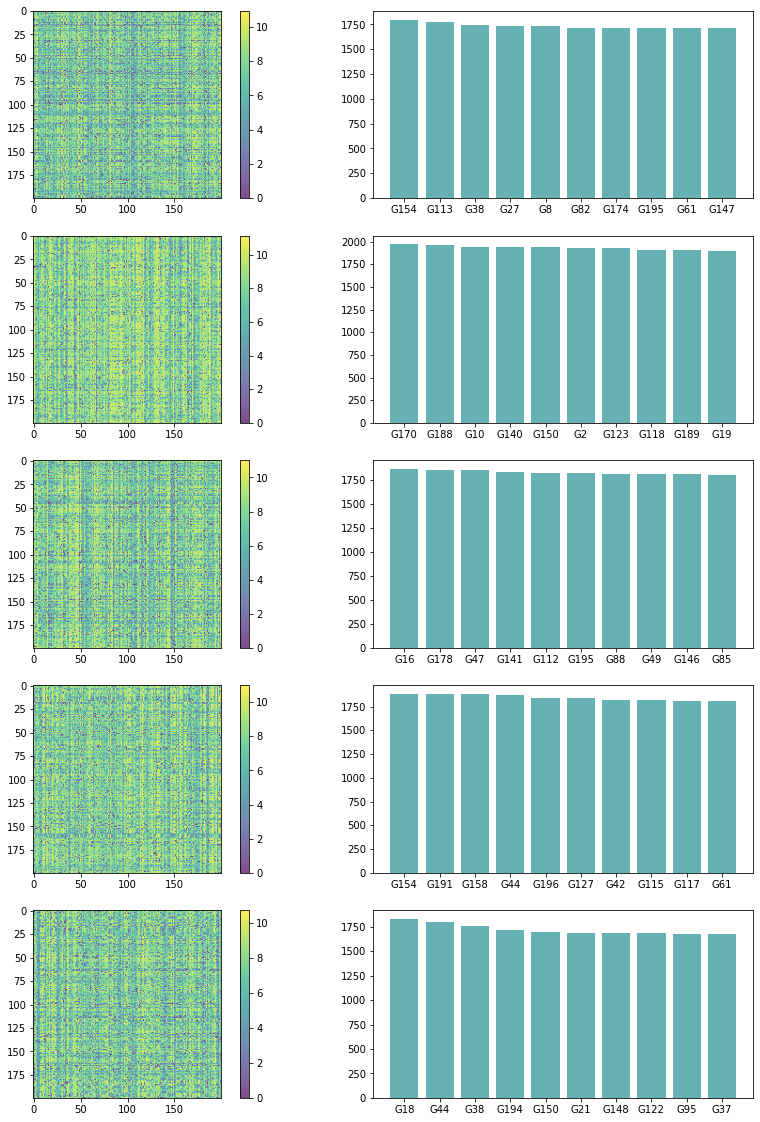

In [5]:
plt.figure(figsize=(15,20))

i = 0
top_common_expressed = {}
for dataset in datasets:

    stats = dataset.sum(axis=0).sort_values(ascending=False)
    top_10 = stats.iloc[:10]

    for k in [10, 20, 50, 100]:
        top_k = stats.iloc[:k]
        if k not in top_common_expressed:
            top_common_expressed[k] = set(top_k.index)
        else:
            top_common_expressed[k] = top_common_expressed[k].intersection(top_k.index)
    
    i += 1
    plt.subplot(5,2,i)
    plt.imshow(dataset, cmap='viridis', alpha=0.7)
    plt.colorbar()

    i += 1
    plt.subplot(5,2,i)
    plt.bar(top_10.index, top_10, color='teal', alpha=0.6)

plt.savefig('heatmaps.pdf')

print(top_common_expressed)

For each dataset we plot a heatmap representing the expression of each gene in each cell, as well as a bar plot of the top $10$ expressed genes in the dataset. By looking at the results we can see that although there are some genes per dataset that are highly expressed, none of them seems to be highly expressed across all five datasets. Morever, the heatmaps appear to be somewhat noisy and there is neither an apparent conclusion from these figures just by looking at them, nor we can easily filter out some genes by consider them outliers or irrelevant features.

### Preprocessing

Before we start performing some kind of dimensionality reduction we should first standardize our datasets in order to have zero mean and unit variance. Thus, we create a simple function using the `StandardScaler` provided by the Python `sklearn` package that does the job for us.

In [6]:
def standardize(X):
    standardized_df = pd.DataFrame(StandardScaler().fit_transform(X))
    standardized_df.index = X.index
    standardized_df.columns = X.columns
    return standardized_df

# standardize all datasets
for i, dataset in enumerate(datasets):
    datasets[i] = standardize(dataset)

standardized_sample_df = standardize(sample_df)
standardized_sample_df

G1        G2        G3        G4        G5        G6        G7  \
Cell                                                                         
C1    0.271371  0.297555  0.611733  0.769026  0.393957  0.139641  0.802463   
C2   -3.446233  0.072025  0.467317  0.921127 -0.174261  0.068731  0.870304   
C3    0.196654  0.268633  0.627637  0.853521  0.291657 -1.688719  0.869510   
C4    0.187043  0.257562  0.541538  0.830958  0.365723  0.068731  0.855410   
C5    0.443174  0.461820  0.460781  0.256703  0.652443  0.659985  0.242589   
...        ...       ...       ...       ...       ...       ...       ...   
C196  0.293474 -0.250074 -0.165543 -2.132181  0.121458 -1.688719 -1.029830   
C197  0.293474  0.246362  0.552739  0.775274  0.304687  0.213328  0.837950   
C198  0.451614  0.411678  0.622793  0.220234 -2.884342  0.846258  0.128279   
C199 -3.446233  0.478221  0.440680 -0.022679  0.576343  0.833116 -0.359291   
C200  0.301561  0.296664  0.554123 -2.132181  0.282801 -1.688719  0.782082   

            G8        G9       G10  ...      G191      G192      G193  \
Cell                                ...                                 
C1    0.051186  0.152308  0.452784  ...  0.488609 -0.038585  0.430860   
C2   -0.091049  0.128101 -0.185436  ...  0.274039 -0.437556  0.316690   
C3    0.068190  0.220537  0.321655  ...  0.344054 -4.058199  0.312918   
C4    0.076482  0.116703  0.383688  ...  0.521212 -0.082363  0.281841   
C5    0.474434  0.429631  0.606105  ...  0.350048  0.379925  0.531734   
...        ...       ...       ...  ...       ...       ...       ...   
C196  0.912381  0.749593 -0.770491  ... -2.564740  0.682168  0.093106   
C197  0.084639  0.253242  0.411514  ...  0.488609 -0.130985  0.311023   
C198  0.543032  0.502300  0.472683  ... -2.564740  0.553443  0.517191   
C199  0.769532  0.620528  0.084949  ...  0.423152  0.795890 -3.077253   
C200 -2.553968  0.193550  0.349569  ...  0.384851 -0.079138  0.289765   

          G194      G195      G196      G197      G198      G199      G200  
Cell                                                                        
C1   -2.428131 -0.006733 -0.085309  0.100958  0.435587 -0.012817 -3.026141  
C2   -2.428131  0.015733 -0.760760 -0.319817 -0.002716 -0.250348 -0.040918  
C3    0.546214 -2.455471  0.060264  0.086319  0.423981 -0.099190  0.069893  
C4    0.534820  0.006231 -0.017231  0.156805  0.372421 -0.113418  0.132923  
C5    0.710654  0.373401  0.686201  0.452886  0.549649  0.452243  0.478040  
...        ...       ...       ...       ...       ...       ...       ...  
C196 -0.384145  0.923447  0.662487 -0.287452 -0.994332  0.965459  0.676631  
C197  0.398422  0.031172 -0.017231  0.269030  0.525727 -2.461549  0.061623  
C198  0.418758  0.544914 -2.473091  0.429897  0.319532  0.601906  0.579337  
C199  0.247927  0.783484  0.782451  0.332279  0.045780  0.815738  0.693424  
C200  0.569604 -2.455471 -0.022166  0.063810  0.361004 -0.095698  0.109379  

[200 rows x 200 columns]

## Dimensionality Reduction

### PCA

Principal components analysis (PCA) consists one of the most well known and broadlyused dimensionality reduction methods.  It discovers axes in high-dimensional space thatcapture the largest amount of variation of our data.  Initially an axis is chosen so that,we can move all of our observations (cells) onto this axis by the shortest possible path.The variance captured by this axis is defined as the variance across the observations alongthat line.  In PCA, the first axis (or “principal component”, PC) is chosen such that itcaptures the greatest variance across observations.  The next PC is chosen such that it isorthogonal to the first and captures the greatest remaining amount of variation, and so on.

By definition, the top PCs are the ones that capture the dominant factors of heterogeneityin the data set.  Thus, we can perform dimensionality reduction usiang PCA, and performfurther analysis using only the top PCs.  This approach is based on the properties of thetheoretical background of PCA, that a low-rank approximation formed from the top PCsis the optimal approximation of the original data for a given matrix rank.

Before performing PCA, as well as the other dimensionality reduction methods, it is im-portant to standardize our data, as mentined in the previous section.  Since PCA seeks to  maximize  the  variance  represented  in  each  successive  principal  component,  it  is  im-portant to normalize or standardize features before performing the PCA transformation.Otherwise, some of the variance detected by PCA could simply be due to the magnitudeof individual variables.

The main objective when we perform PCA is to decide regarding the number of the com-ponents (PCs), that we are going to obtain in order to perform the further analysis.  Todecide on the number of components we used the following two methods that are analyzedbelow:

#### Choosing the number of Components

1. **Cumulative Variance Criterion**:One way to decide regarding the number of components that should be used for further analysis, is to retain all PCs until the percentage of total variation explained reaches some threshold. For example, we might retain the top set of PCs that explains 80\% or 95\% of the total variation in the data.  Using our sample dataset, we plot the cumulative variance of PCA against the number of components. 

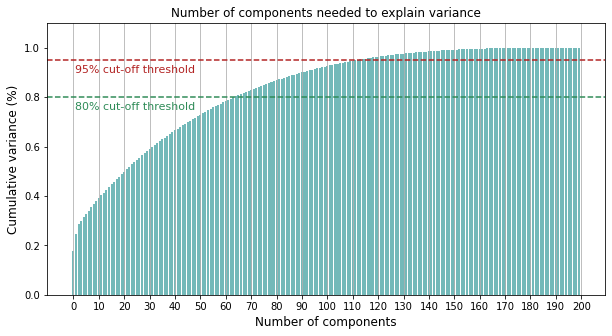

In [7]:
pca = PCA().fit(standardized_sample_df)
var_exp = pca.explained_variance_ratio_


x = np.arange(0, len(standardized_sample_df))
y = np.cumsum(var_exp)


fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(x, y, color='teal', alpha=0.55)
plt.axhline(y=0.95, color='firebrick', linestyle='--')
plt.text(0.5, 0.9, '95% cut-off threshold', color='firebrick', fontsize=11)
plt.axhline(y=0.80, color='seagreen', linestyle='--')
plt.text(0.5, 0.75, '80% cut-off threshold', color='seagreen', fontsize=11)
plt.xlabel('Number of components', fontsize=12)
plt.ylabel('Cumulative variance (%)', fontsize=12)
plt.title('Number of components needed to explain variance', fontsize=12)
plt.ylim(0, 1.1)
plt.xticks(np.arange(0, 201, step=10))
ax.grid(axis='x')
plt.savefig('cum_var.pdf')

We plot the same diagram for all the datasets.

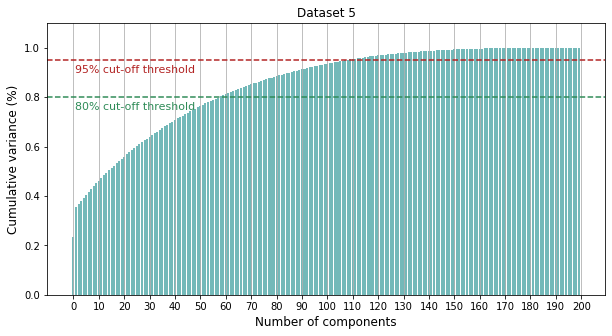

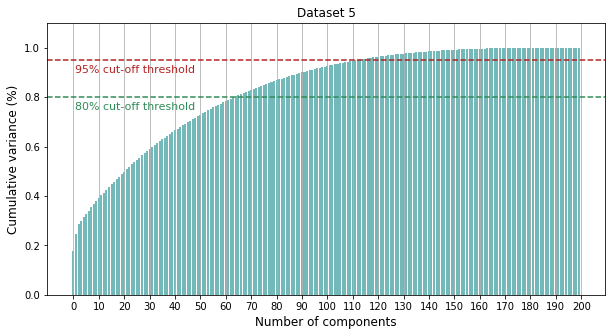

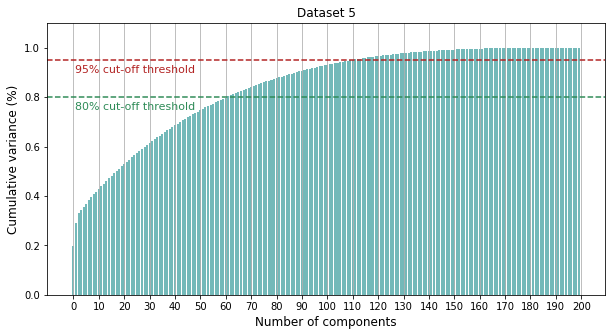

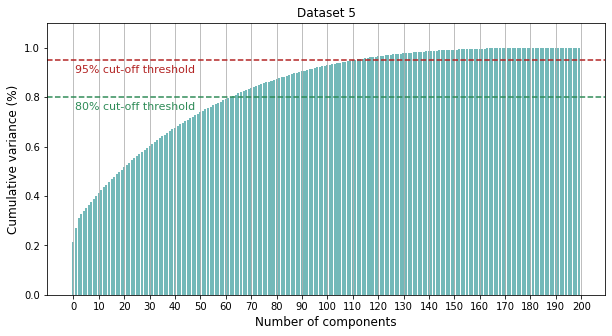

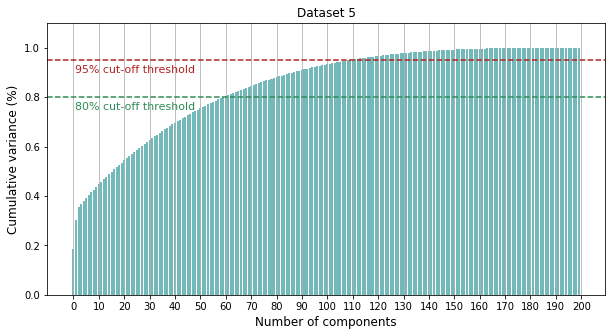

In [8]:
for dataset in datasets:
    
    pca = PCA().fit(dataset)
    var_exp = pca.explained_variance_ratio_

    x = np.arange(0, len(dataset))
    y = np.cumsum(var_exp)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.bar(x, y, color='teal', alpha=0.55)
    plt.axhline(y=0.95, color='firebrick', linestyle='--')
    plt.text(0.5, 0.9, '95% cut-off threshold', color='firebrick', fontsize=11)
    plt.axhline(y=0.80, color='seagreen', linestyle='--')
    plt.text(0.5, 0.75, '80% cut-off threshold', color='seagreen', fontsize=11)
    plt.xlabel('Number of components', fontsize=12)
    plt.ylabel('Cumulative variance (%)', fontsize=12)
    plt.title(f'Dataset {i+1}', fontsize=12)
    plt.ylim(0, 1.1)
    plt.xticks(np.arange(0, 201, step=10))
    ax.grid(axis='x')
    plt.savefig(f'cum_var_dataset{i+1}.pdf')

As depicted in the figures, $\approx 110$ components are required in order to achieve the $95\%$ of the cumulative variance. Moreover, it is shown that almost the half, $\approx 65$, components are required to achieve the $80\%$ of the cumulative variance. 

Using this method one can simply select the number of components per dataset. However, this number of PCs computationally is quite expensive and moreover by selecting a large number of PCs, we apart from explained variance, we include more noise in our dataset as well. 



2. **Individual Variance Criterion:** Another option for choosing the appropriate number of PCs involves identifying the elbow point in the percentage of variance explained by successive PCs (individual variance of a PC). This refers to the “elbow” in the curve of a scree plot. A scree plot is a line plot of the eigenvalues of the PCs form the PCA. This assumption is based on the fact that each of the top PCs should explain much more variance than the remaining PCs. From a practical perspective, the use of the elbow point tends to retain fewer PCs compared to the previous method. Using our sample dataset, we plot the cumulative variance of PCA against the number of components. 

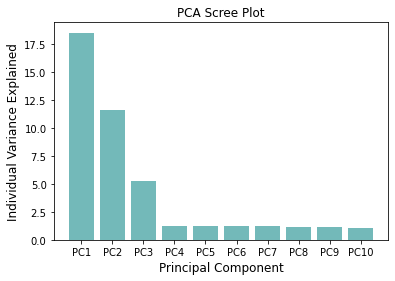

In [9]:
percent_variance = np.round(var_exp[0:10]* 100, decimals =3)
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

plt.bar(x= range(10), height=percent_variance, tick_label=columns, color='teal', alpha=0.55)
plt.ylabel('Individual Variance Explained', fontsize=12)
plt.xlabel('Principal Component', fontsize=12)
plt.title('PCA Scree Plot', fontsize=12)
plt.savefig('in_var.pdf')

From the above analysis, we could assume that the appropriate number of components that should be used to proceed with the clustering is between 2-5. However, a more extensive evaluation regarding the number of components is carried out in the following sections.

We have created a simple function for running PCA into a given  dataset, using the `PCA` function provided by the Python `sklearn` package. Further analysis is made in Appendix B, regarding the specific function and the tuning of its parameters. 

In [10]:
def pca(X, variance=0.95):
    reduced_df = pd.DataFrame(PCA(n_components=variance).fit_transform(X))
    reduced_df.index = X.index
    return reduced_df

reduced_sample_df = pca(standardized_sample_df)
reduced_sample_df

0         1         2         3         4         5         6    \
Cell                                                                         
C1    3.519604 -0.471410 -3.458377 -0.975478 -0.050801 -0.230170  0.793775   
C2    6.229249  3.109439 -2.354581 -1.184918  0.035958 -0.450510 -2.237445   
C3    5.659589 -1.150563 -0.339799  1.031315  1.054391 -2.863455 -2.892434   
C4    5.528048 -1.086818 -2.078280 -0.186510 -0.042720 -0.357302  1.988543   
C5   -2.261521 -5.132304 -0.667293 -0.065146  0.104303  0.345328 -0.775356   
...        ...       ...       ...       ...       ...       ...       ...   
C196 -9.669578  5.222215  3.482341 -3.685096  2.285755  3.145926  0.116849   
C197  5.086730 -0.976190 -1.583526 -0.420293  0.585360  0.345273 -1.430432   
C198 -3.693236 -3.098242 -1.363477  0.424698 -1.986077  0.618272 -1.071138   
C199 -5.051428 -2.594794 -1.259919  0.865508 -0.905483 -0.445785 -0.398824   
C200  4.002010  0.081728 -1.922862  0.612956  0.227782  0.834635  1.399691   

           7         8         9    ...       103       104       105  \
Cell                                ...                                 
C1    0.656539 -1.101178 -1.565495  ...  0.208382  0.508040  0.833504   
C2    0.896753 -0.832519 -1.129936  ...  0.051827 -0.773585 -0.697233   
C3    1.411269 -1.057202 -0.871924  ... -0.004267  0.493707 -0.296583   
C4    1.678806  0.121453  1.282003  ... -0.301077  0.702798 -1.019892   
C5   -0.246617 -1.397757  0.880741  ...  0.472439 -0.403198  0.377996   
...        ...       ...       ...  ...       ...       ...       ...   
C196  0.230097  0.060198  2.120950  ... -0.451252  0.857525  1.066236   
C197  0.740876  1.570996  0.580423  ...  1.363136 -0.040817  1.260188   
C198 -0.923060 -2.151158  0.787550  ... -0.187384 -1.110504 -0.582184   
C199  0.219390 -0.392677 -0.304732  ...  0.218471 -0.376992 -0.034206   
C200 -0.244408  0.412421 -0.356777  ...  0.851686  0.282036 -0.442769   

           106       107       108       109       110       111       112  
Cell                                                                        
C1   -0.092679 -0.075524  0.284262  0.052988 -0.397059 -0.048167 -1.373747  
C2    1.096028 -0.063826  0.195129  0.467668 -0.885487 -0.102250  1.946982  
C3    0.249730  0.536590  0.241155 -0.477680  0.490595 -0.662532  0.395197  
C4   -0.377575 -0.539377  1.511647 -0.787874  0.106029 -0.114301  1.157292  
C5   -0.401921 -0.848314 -0.436371 -0.090449 -1.115917 -0.917330 -0.428344  
...        ...       ...       ...       ...       ...       ...       ...  
C196 -0.296417 -0.467715 -1.612458 -0.076526 -0.467238 -0.027527  0.308933  
C197 -0.773813  0.306210 -0.044441  0.227861  0.141997 -0.001068 -0.461811  
C198  0.409697 -0.475246 -0.494710  0.948174 -0.179725  0.204747  0.560496  
C199  1.028252 -0.795005  0.100764  1.050900 -0.033954 -0.219407  0.609085  
C200 -0.507762  0.221368 -0.292079 -1.065138  0.674859  0.050465  0.196099  

[200 rows x 113 columns]

As expected from looking at the previously presented cumulative variance figure, the number of components extracted by PCA for this sample dataset are $\approx 100$. Unfortunately, we cannot visualize $100$ dimensions (since we are not mathematicians). However, we run PCA by keeping $2$ and $3$ components and vizualize the results in order to show that PCA cannot easily form well-shaped clusters in such a low-dimensional space.

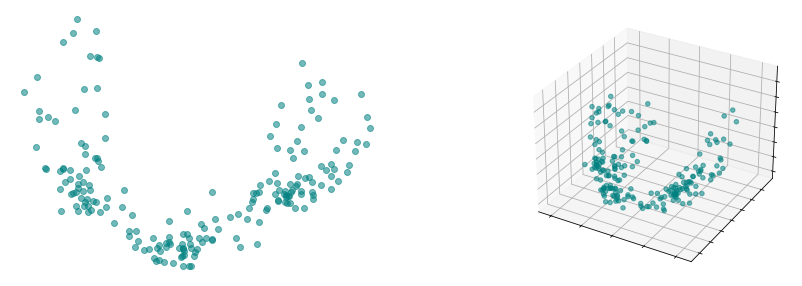

In [11]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
reduced_2d = pca(standardized_sample_df, 2)
plt.scatter(reduced_2d.iloc[:, 0], reduced_2d.iloc[:, 1], color='teal', alpha=0.55)
plt.axis('off')

ax = fig.add_subplot(122, projection='3d')
reduced_3d = pca(standardized_sample_df, 3)
ax.scatter(reduced_3d.iloc[:, 0], reduced_3d.iloc[:, 1], reduced_3d.iloc[:, 2], color='teal', alpha=0.55)
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])

plt.savefig('sample_PCA.pdf')

### t-SNE

T-Distributed Neighbor Embedding (t-SNE)\cite{tsne}, is a non linear dimensionality reduction method that was introduced in 2008 and visualizes high-dimensional data by giving each datapoint a location in a two or three-dimensional map. In brief t-SNE works as follows:\\

- Given a set of $N$ multidimensional observations $X{=}(\mathbf{x_1}, \mathbf{x_2}, \dots, \mathbf{x_N}) $,  t-SNE first computes probabilities $p_{i|j}$, that are proportional to the similarity of objects $\mathbf{x_i}$ and $\mathbf{x_j}$, as follows. For $i \neq j$ define:
\begin{equation*}
      p_{j\mid i}={\frac {\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{j}\rVert ^{2}/2\sigma _{i}^{2})}{\sum _{k\neq i}\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{k}\rVert ^{2}/2\sigma _{i}^{2})}}
\end{equation*}
and set $p_{i\mid i}=0$ and we know that $\sum _{j}p_{j\mid i}=1$ for all $i$.

- As explained in the paper\cite{tsne} : "The similarity of datapoint $x_{j}$ to datapoint $x_{i}$ is the conditional probability, $p_{j|i}$, that $x_{i}$ would pick $x_{j}$ as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at $x_{i}$.

- The bandwidth of the Gaussian kernels $\sigma _{i}$ is set in such a way that the perplexity of the conditional distribution equals a predefined perplexity using the bisection method. As a result, the bandwidth is adapted to the density of the data: smaller values of $\sigma _{i}$ are used in denser parts of the data space. Since the Gaussian kernel uses the Euclidean distance  $\lVert x_{i}-x_{j}\rVert$, it is affected by the curse of dimensionality, and in high dimensional data when distances lose the ability to discriminate, the $p_{ij}$ become too similar (asymptotically, they would converge to a constant). It has been proposed to adjust the distances with a power transform, based on the intrinsic dimension of each point, to alleviate this.

- t-SNE aims to learn a $d$-dimensional map $\mathbf {y}_{1},\dots ,\mathbf {y} _{N}$ (with $\mathbf {y}_{i}\in \mathbb {R} ^{d}$ $\mathbf {y} _{i}\in \mathbb {R} ^{d})$ that reflects the similarities $p_{ij}$ as well as possible. To this end, it measures similarities $q_{ij}$ between two points in the map $\mathbf{y} _{j} \mathbf {y} _{j}$, using a very similar approach. Specifically, for $i\neq j$, define $q_{ij}$ as

\begin{equation*}
    q_{ij}={\frac {(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}}{\sum _{k}\sum _{l\neq k}(1+\lVert \mathbf {y} _{k}-\mathbf {y} _{l}\rVert ^{2})^{-1}}}
\end{equation*} 
and set $q_{ii}=0$. 

- The locations of the points $\mathbf {y} _{i}$ in the map are determined by minimizing the Kullback–Leibler divergence of the distribution $P$ from the distribution $Q$, that is:

\begin{equation*}
   \mathrm {KL} \left(P\parallel Q\right)=\sum _{i\neq j}p_{ij}\log {\frac {p_{ij}}{q_{ij}}}
\end{equation*}

The minimization of the Kullback–Leibler divergence with respect to the points $\mathbf {y} _{i}$ is performed using gradient descent. The result of this optimization is a map that reflects the similarities between the high-dimensional inputs. 
\end{itemize}

The performance of t-SNE is fairly robust under different settings of the perplexity. The most appropriate value depends on the density of the data. It is said, that a larger / denser dataset requires a larger perplexity. Typical values for the perplexity are suggested to be in range between 5 and 50. Perplexity is a measure for information that is defined as 2 to the power of the Shannon entropy. In t-SNE, the perplexity may be viewed as a knob that sets the number of effective nearest neighbors.

In order to visualize the effect of the preplexity parameter, we create a simple function for running t-SNE into a given dataset, using the `TSNE` function provided by the Python `sklearn` package.

In [12]:
def tsne(X, n_components, perplexity=30):
    reduced_df = pd.DataFrame(TSNE(n_components=n_components, perplexity=perplexity).fit_transform(X))
    reduced_df.index = X.index
    return reduced_df

First we apply the t-SNE dimensionality reduction to the sample dataset and plot the results for $2$ and $3$ components in order to get an intuition about the results.

/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aspa/

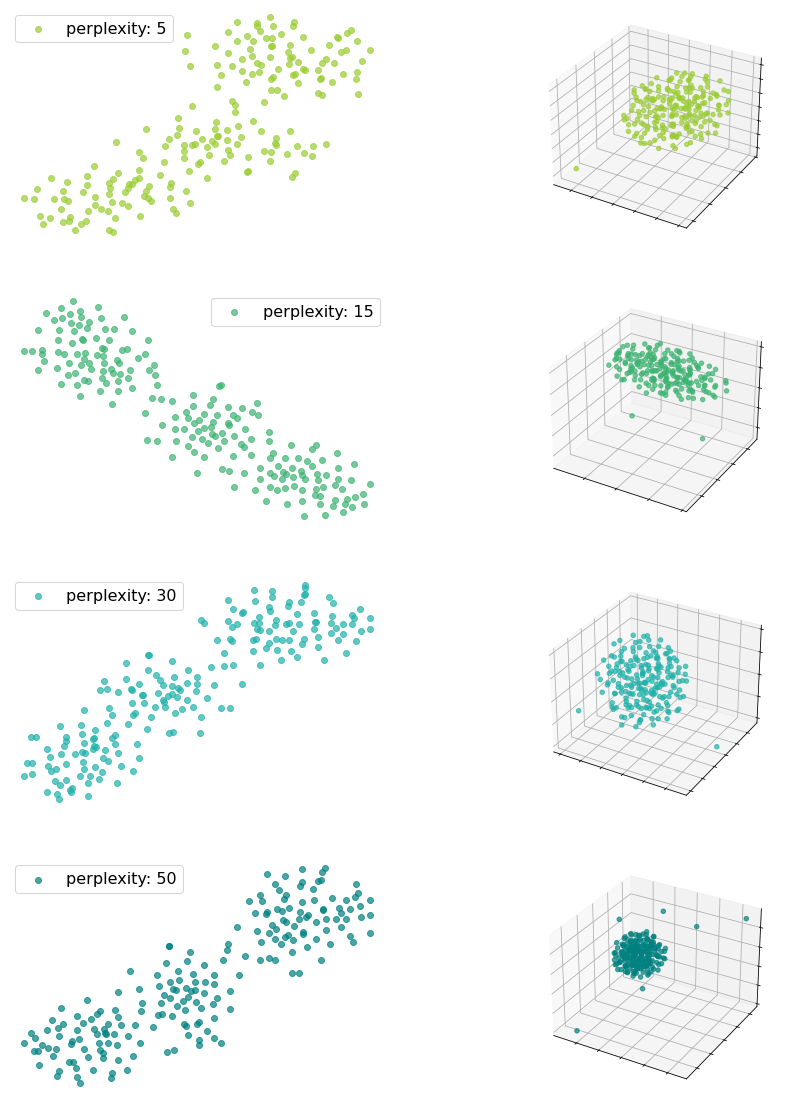

In [13]:
fig = plt.figure(figsize=(15, 20))

perplex = {'5': 'yellowgreen', '15': 'mediumseagreen', '30': 'lightseagreen', '50': 'teal'}

i = 0
for perplexity in [5, 15, 30, 50]:
    
    i += 1
    fig.add_subplot(4,2,i)
    reduced_2d = tsne(standardized_sample_df, 2, 15)
    plt.scatter(reduced_2d.iloc[:, 0], reduced_2d.iloc[:, 1],
                label=f'perplexity: {perplexity}', color=perplex[str(perplexity)], alpha=0.7)
    plt.legend(fontsize=16)
    plt.axis('off')

    i += 1
    ax = fig.add_subplot(4,2,i, projection='3d')
    reduced_3d = tsne(standardized_sample_df, 3, 15)
    ax.scatter(reduced_3d.iloc[:, 0], reduced_3d.iloc[:, 1], reduced_3d.iloc[:, 2],
               color=perplex[str(perplexity)], alpha=0.7)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])

plt.savefig('tsne_per.pdf', bbox_inches='tight', pad_inches = 0)

we note that in the 3D space, t-SNE tends to map the data in very compact structures with uniformly distributed points for all the datasets. We observe that for a \texttt{perplexity} of 15, we get the better visualization for our data. To that end we decide to proceed using the following parameters for t-SNE:

- **number of components: 2**
- **preplexity: 15**


### UMAP: Uniform Manifold Approximation

The uniform manifold approximation and projection (UMAP) method is an alternative to t-SNE for non-linear dimensionality reduction. UMAP works very similar to t-SNE, use try to arrange data in low-dimesional space, trying to preserve relationships between neighbors in high-dimensional space. However, the two methods are based on different theory, represented by differences in the various graph weighting equations.

In order to construct the initial high-dimensional graph, UMAP builds a fuzzy simplicial complex. This is a representation of a weighted graph, with edge weights representing the likelihood that two points are connected. To determine connectedness, UMAP extends a radius outwards from each point, connecting points when those radii overlap. Choosing this radius is critical, since too small a choice will lead to small, isolated clusters, while too large a choice will connect everything together. UMAP overcomes this challenge by choosing a radius locally, based on the distance to each point's nth nearest neighbor. UMAP then makes the graph "fuzzy" by decreasing the likelihood of connection as the radius grows. Finally, by stipulating that each point must be connected to at least its closest neighbor, UMAP ensures that local structure is preserved in balance with global structure. Once the high-dimensional graph is constructed, UMAP optimizes the layout of a low-dimensional analogue to be as similar as possible, the same way as t-SNE does. 

In general, while both algorithms tend to exhibit strong local clustering and group similar categories together, UMAP  is able to clearly separate the subclusters of a cluster from each other. 

Similar to t-SNE, in order to visualize the effect of the parameters we create a simple function for running UMAP into a given dataset, using the `umap` Python package.

In [14]:
def _umap(X, n_components, n_neighbors=15, min_dist=0.1):
    mapper = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
    reduced_df = pd.DataFrame(mapper.fit_transform(X))
    reduced_df.index = X.index
    return reduced_df

#### Parameter Selection

In general, the two most commonly used parameters are \texttt{n\_neighbors} and \texttt{min\_dist}, which are effectively used to control the balance between local and global structure in the final projection.

1. **Number of neighbors**: This parameter refers to the number of approximate nearest neighbors used to construct the initial high-dimensional graph. It controls how UMAP balances local versus global structure. We know that low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

We apply the UMAP dimensionality reduction to the sample dataset and plot the results for $2$ and $3$ components and different values for the number of neighbors and the minimum distance parameters in order to get an intuition about the effect of the parameters.

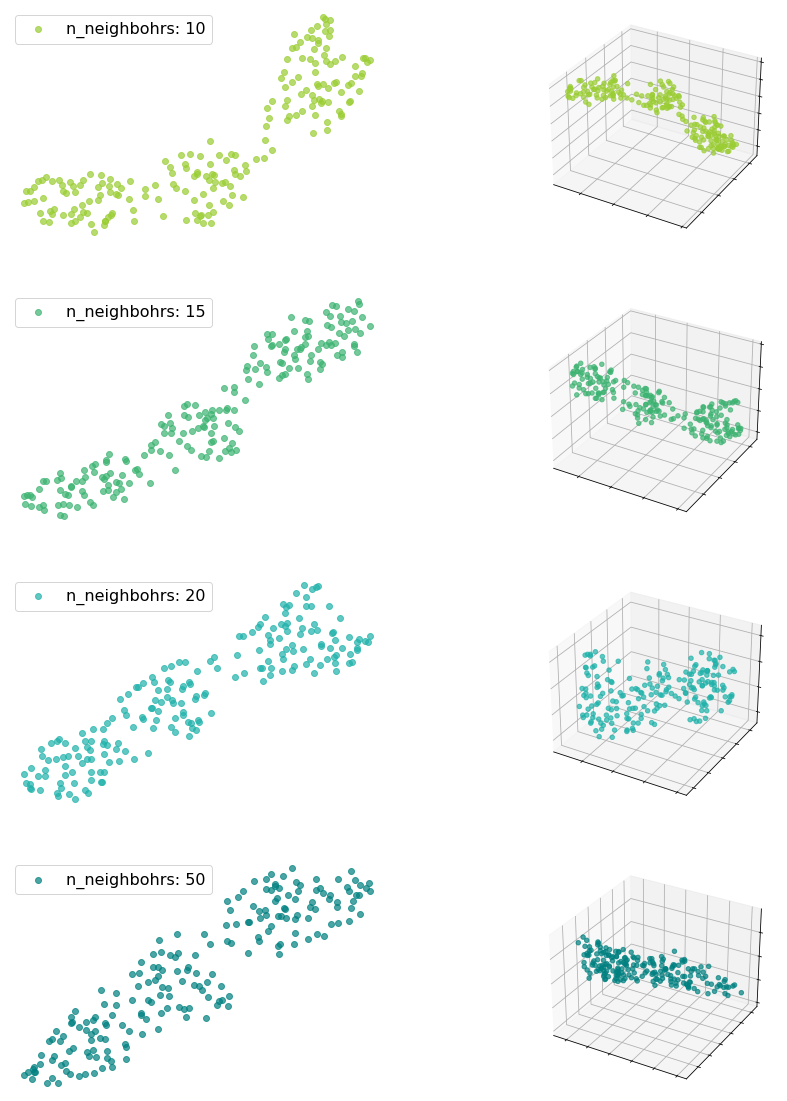

In [15]:
fig = plt.figure(figsize=(15, 20))

neighbors = {'10': 'yellowgreen', '15': 'mediumseagreen', '20': 'lightseagreen', '50': 'teal'}


i = 0
for n_neighbors in [10, 15, 20, 50]:
    
    i += 1
    fig.add_subplot(4,2,i)
    reduced_2d = _umap(standardized_sample_df, 2, n_neighbors)
    plt.scatter(reduced_2d.iloc[:, 0], reduced_2d.iloc[:, 1],
                label=f'n_neighbohrs: {n_neighbors}', color=neighbors[str(n_neighbors)], alpha=0.7)
    plt.legend(fontsize=16)
    plt.axis('off')

    i += 1
    ax = fig.add_subplot(4,2,i, projection='3d')
    reduced_3d = _umap(standardized_sample_df, 3, n_neighbors)
    ax.scatter(reduced_3d.iloc[:, 0], reduced_3d.iloc[:, 1], reduced_3d.iloc[:, 2],
               color=neighbors[str(n_neighbors)], alpha=0.7)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])

plt.savefig('umap_neighbors.pdf', bbox_inches='tight', pad_inches = 0)

We note that as the number of neighbors increases, the predicted structures, as expected, tend to unify and become more compact. We can conclude that for **number of neighbors=15**, we get the best results for 2 and 3 components as well.

2. **Minimum Distance:** This parameter controls how tightly UMAP colocates points together. In general, low values lead to more tightly packed embeddings, while larger values make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.

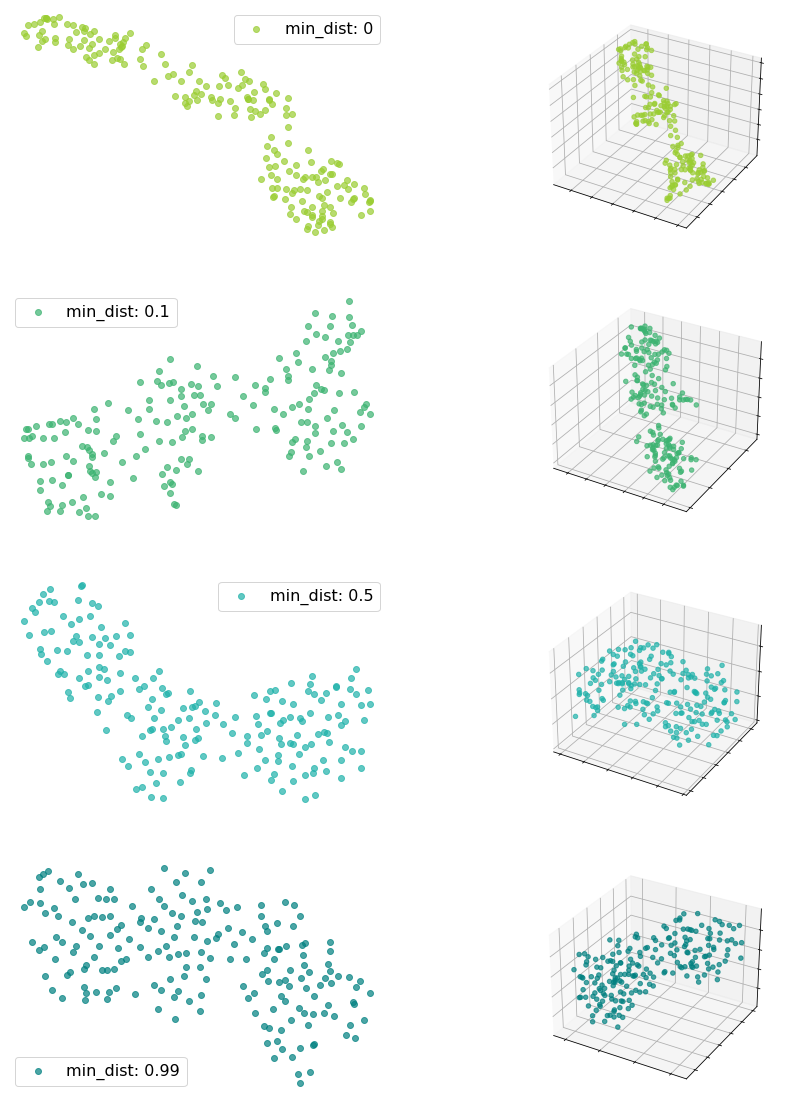

In [16]:
fig = plt.figure(figsize=(15, 20))

distances = {'0': 'yellowgreen', '0.1': 'mediumseagreen', '0.5': 'lightseagreen', '0.99': 'teal'}

i = 0
for min_dist in [0, 0.1, 0.5, 0.99]:
    
    i += 1
    fig.add_subplot(4,2,i)
    reduced_2d = _umap(standardized_sample_df, 2, 15, min_dist)
    plt.scatter(reduced_2d.iloc[:, 0], reduced_2d.iloc[:, 1],
                label=f'min_dist: {min_dist}', color=distances[str(min_dist)], alpha=0.7)
    plt.legend(fontsize=16)
    plt.axis('off')

    i += 1
    ax = fig.add_subplot(4,2,i, projection='3d')
    reduced_3d = _umap(standardized_sample_df, 3, 15, min_dist)
    ax.scatter(reduced_3d.iloc[:, 0], reduced_3d.iloc[:, 1], reduced_3d.iloc[:, 2],
               color=distances[str(min_dist)], alpha=0.7)
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])

plt.savefig('umap_min_dist.pdf', bbox_inches='tight', pad_inches = 0)

We present the effect of different values of `min_dist` in the predicted structures for $2$ and $3$ components. We note that as the value of the minimum distance between the neighbors increases, the predicted structures, as expected, tend to unify and become more compact. We can conclude that for **minimum distance between 0 and 0.1**, we get the best results for 2 and 3 components as well. In 3 dimensions we note that the most well structures result is obtained for `min_dist = 0.5`.

## Gaussian Mixture Models

Superpositions formed by taking linear combinations of Gaussian distributions, can be formulated as probabilistic models known as mixture distributions. We therefore define a superposition of $K$ Gaussian densities of the form

\begin{equation*}
    p(\mathbf{x}) = \sum_{k=1}^K \pi_k\mathcal{N}(\mathbf{x}|\boldsymbol\mu_k, \mathbf{\Sigma}_k)
\end{equation*}

which is called a mixture of Gaussians. Each Gaussian density is called a component of the mixture and the parameters $\pi_k$ are called the mixing coefficients. By using a sufficient number of Gaussians, and by optimizing their means and covariances, as well as the coefficients $\pi_k$ in the linear combination, almost any continuous density can be approximated to arbitrary accuracy.

Thus, a Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions having unknown parameters. One can think of mixture models as generalizing $k$-means clustering to incorporate information about the covariance structure of the data, as well as the centers of the latent Gaussians.

Given a dataset $\mathbf{X}=\{\mathbf{x}_1\dots\mathbf{x}_N\}$, one way of finding the values of the parameters is to use maximum likelihood. Due to the presence of the summation over $k$ inside the logarithm, the derivation is complex, and as a result, the maximum likelihood solution for the parameters does not have a closed-form analytical solution. One approach to maximizing the likelihood function is to employ the Expectation-Maximization technique.

In [17]:
# Global parameters used for the analysis below.
cov_markers = {'full': 's', 'tied': 'x', 'diag': 'D', 'spherical': 'o'}
component_colors = [
    'khaki',
    'yellowgreen',
    'mediumaquamarine',
    'mediumturquoise',
    'lightseagreen',
    'teal',
    'darkslategray'
]
number_of_states = range(2, 10)

We create a simple function for running GMMs for a given dataset, using the \texttt{gmm} function of the Python package `sklearn`. The custom `gmm` function takes as input the reduced dataset, the number of states we want to predict and four types of covariance matrix.

In [18]:
def gmm(X, candidate_states, candidate_cov_types=['full','tied', 'diag', 'spherical']):
    """
    Computes the Gaussian Mixture Models for each given covariance matrix type and
    candidate states over the given dataset.
    
    :return: four dictionaries, holding the BIC scores, the delta BIC scores, the
             predictions, and the posterior probabilities. Each of the dictionaries
             has the following form:
             
             {
                 covariance_matrix_type: list of values
             }
    """
    bic = {}
    delta_bic = {}
    predictions = {}
    prob_predictions = {}
    silhouette = {}
    for cov_type in candidate_cov_types:
        cov_bic = []
        cov_delta_bic = []
        cov_pred = []
        cov_prob = []
        cov_silhouette = []
        for n_states in candidate_states:
            clf = mixture.GaussianMixture(n_components=n_states, covariance_type=cov_type)
            clf.fit(X)
        
            cov_bic.append(clf.bic(X))
            cov_pred.append(clf.predict(X))
            cov_prob.append(clf.predict_proba(X))
            cov_silhouette.append(silhouette_score(X, cov_pred[-1]))
        
        # compute delta BIC that is candidate BIC - best BIC, for each candidate.
        best_bic = min(cov_bic)
        for candidate_bic in cov_bic:
            cov_delta_bic.append(candidate_bic - best_bic)
        
        bic[cov_type] = cov_bic
        delta_bic[cov_type] = cov_delta_bic
        predictions[cov_type] = cov_pred
        prob_predictions[cov_type] = cov_prob
        silhouette[cov_type] = cov_silhouette
    
    return bic, delta_bic, predictions, prob_predictions, silhouette

### Results

In order to decide the best model for the given datasets, we designed a pipeline that should be followed in order to understand the data and approximate the actual number of clusters (true distribution) that generated the observed datasets. In this section we present the results obtained from an exploratory data analysis using three dimensionality reduction techniques and the Gaussian mixture models over various parameter configurations.

### PCA & GMM


As discussed previously, we need to decide the best number of components for PCA. Moreover, for fitting a Gaussian mixture model (GMM) on the data, we need to specify the type of the covariance matrix, as well as the number of clusters (states). In order to decide on these parameters we ran a swipe over a range of values for these parameters and scored each model using both the BIC criterion and the Silhouette score.

In [19]:
number_of_components = [2, 3, 4, 5]

reduced = []
results = []
for dataset in datasets:
    component_bic_scores = {}
    component_delta_bic_scores = {}
    component_pred = {}
    component_prob = {}
    component_silhouette = {}
    reduced.append({})
    for n in number_of_components:
        reduced[-1][n] = pca(dataset, n)
        bic, delta_bic, predictions, prob_predictions, silhouette = gmm(reduced[-1][n], number_of_states)
        component_bic_scores[n] = bic
        component_delta_bic_scores[n] = delta_bic
        component_pred[n] = predictions
        component_prob[n] = prob_predictions
        component_silhouette[n] = silhouette
    results.append({
        'bic': component_bic_scores,
        'delta_bic': component_delta_bic_scores,
        'pred': component_pred,
        'probs': component_prob,
        'silhouette': component_silhouette
    })

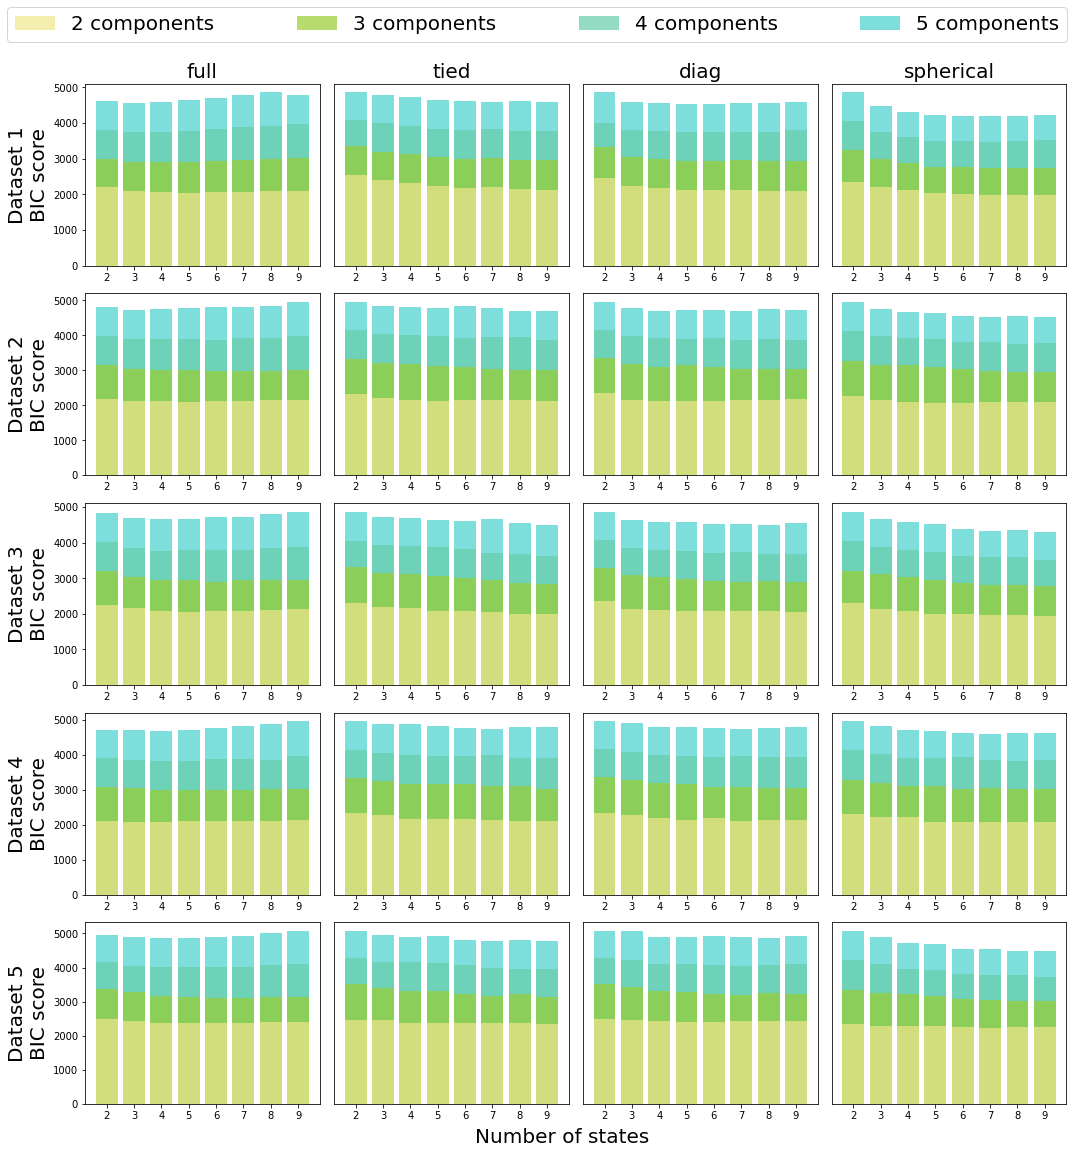

In [20]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['bic'].items()):
            
            l = f'{j + min(number_of_components)} components' if step == 1 else ''
            plt.bar(number_of_states, scores[cov_type], color=component_colors[j],
                    zorder=len(number_of_components)-j, label=l, alpha=0.7)

            if i == 0:
                plt.title(cov_type, fontsize=20)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\nBIC score', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)
plt.savefig('PCA_BIC.pdf', bbox_inches='tight', pad_inches = 0)

The results for the BIC score are presented above. Each row of the matrix refers to a specific dataset, while each column to a specific covariance matrix type. Every bar plot in the matrix plots the BIC score against the number of states (clusters) used by the GMM. Each bar color refers to a different number of components for the PCA. The results indicate that the lowest BIC score is achieved by simpler models in terms of PCA components, as they achieve the lowest BIC score regardless of the number of clusters and covariance matrix type.

On the other hand, the plot below depicts the $\Delta$BIC instead of BIC. The results in this case suggest that the full covariance matrix type seems to achieve its best BIC score using a smaller number of components than every other covariance matrix type, since most of them require more than $6$ components.

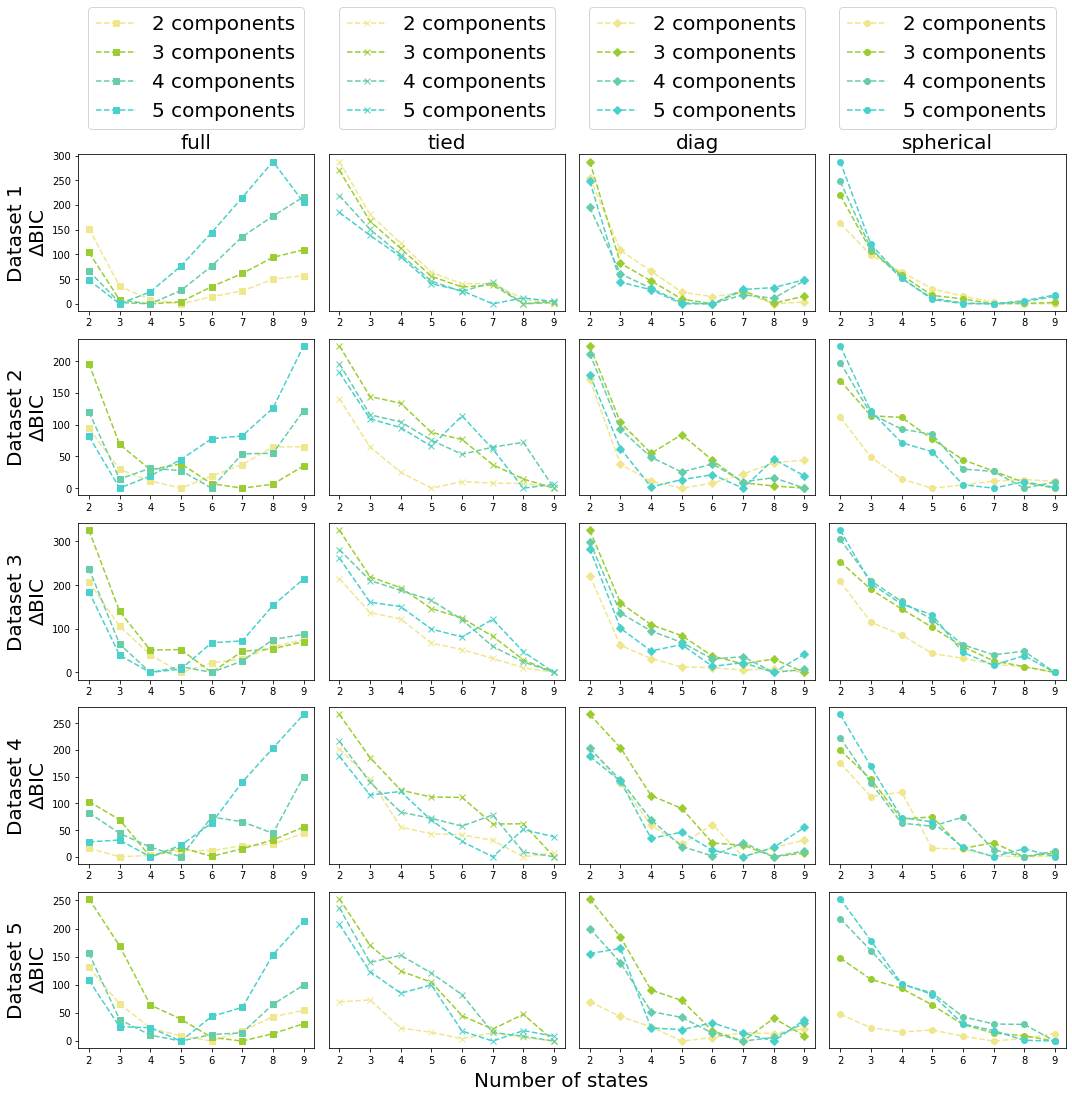

In [21]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['delta_bic'].items()):
            
            l = f'{j + min(number_of_components)} components' if step < 5 else ''
            plt.plot(number_of_states, scores[cov_type], color=component_colors[j], 
                     linestyle = '--', marker=cov_markers[cov_type], label=l)
        
            if i == 0:
                plt.title(cov_type, fontsize=20)
                plt.legend(bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=1, fontsize=20)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\n$\Delta$BIC', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
plt.savefig('PCA_DBIC.pdf', bbox_inches='tight', pad_inches = 0)

We plot the Silhouette score instead of the BIC score.

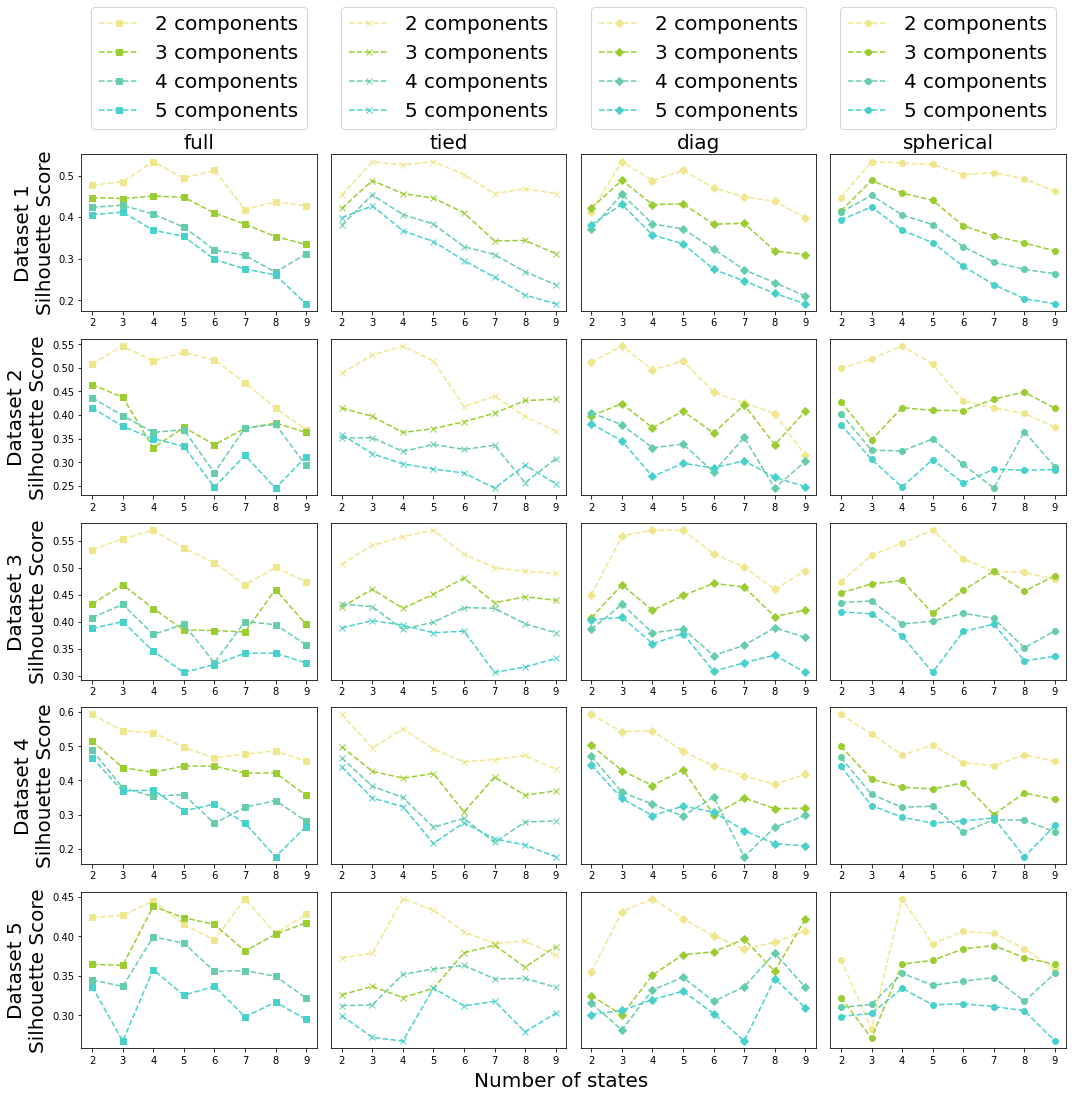

In [22]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['silhouette'].items()):
            
            l = f'{j + min(number_of_components)} components' if step < 5 else ''
            plt.plot(number_of_states, scores[cov_type], color=component_colors[j], 
                     linestyle = '--', marker=cov_markers[cov_type], label=l)
        
            if i == 0:
                plt.title(cov_type, fontsize=20)
                plt.legend(bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=1, fontsize=20)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\nSilhouette Score', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
plt.savefig('PCA_sihlouette.pdf', bbox_inches='tight', pad_inches = 0)

Form the plots above, we observe, that the higher scores are achieved by using $2$ components in every covariance matrix type. Moreover, the score seems to achieve its maximum value for fewer components (generally less than $6$) in all cases.

We plot a matrix of the GMM clustering results using only the full covariance matrix. For each dataset we mark using a green color the clustering that achieved the best BIC score.

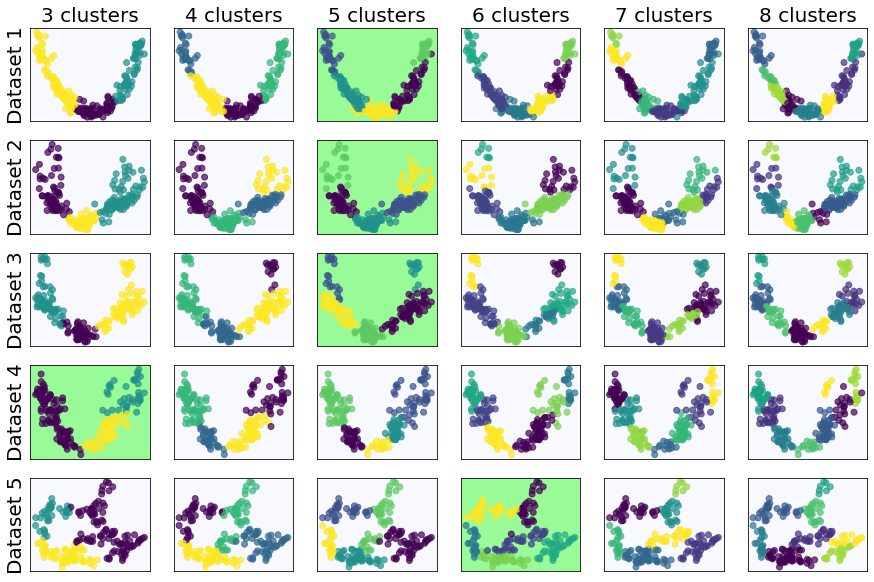

In [23]:
fig = plt.figure(figsize=(15, 10))

step = 1
for i in range(len(datasets)):
    
    best_bic = min(results[i]['bic'][2]['full'])
    best_bic_idx = results[i]['bic'][2]['full'].index(best_bic)
    
    for n_states in range(3, 9):
        idx = number_of_states.index(n_states)
        
        ax = plt.subplot(len(datasets), 6, step)
        plt.scatter(reduced[i][2].iloc[:, 0], reduced[i][2].iloc[:, 1], 
                    c=results[i]['pred'][2]['full'][idx], cmap='viridis', alpha=0.7)
        
        if i == 0:
            plt.title(f'{n_states} clusters', fontsize=20)
        if step in [1, 7, 13, 19, 25]:
                plt.ylabel(f'Dataset {i+1}', fontsize=20)

        if number_of_states[best_bic_idx] == n_states:
            ax.set_facecolor('palegreen')
        else:
            ax.set_facecolor('ghostwhite')
        
        plt.xticks([]); plt.yticks([])

        step += 1
plt.savefig('PCA_2Dclusters.pdf', bbox_inches='tight', pad_inches = 0)

/tmp/ipykernel_15178/631770224.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


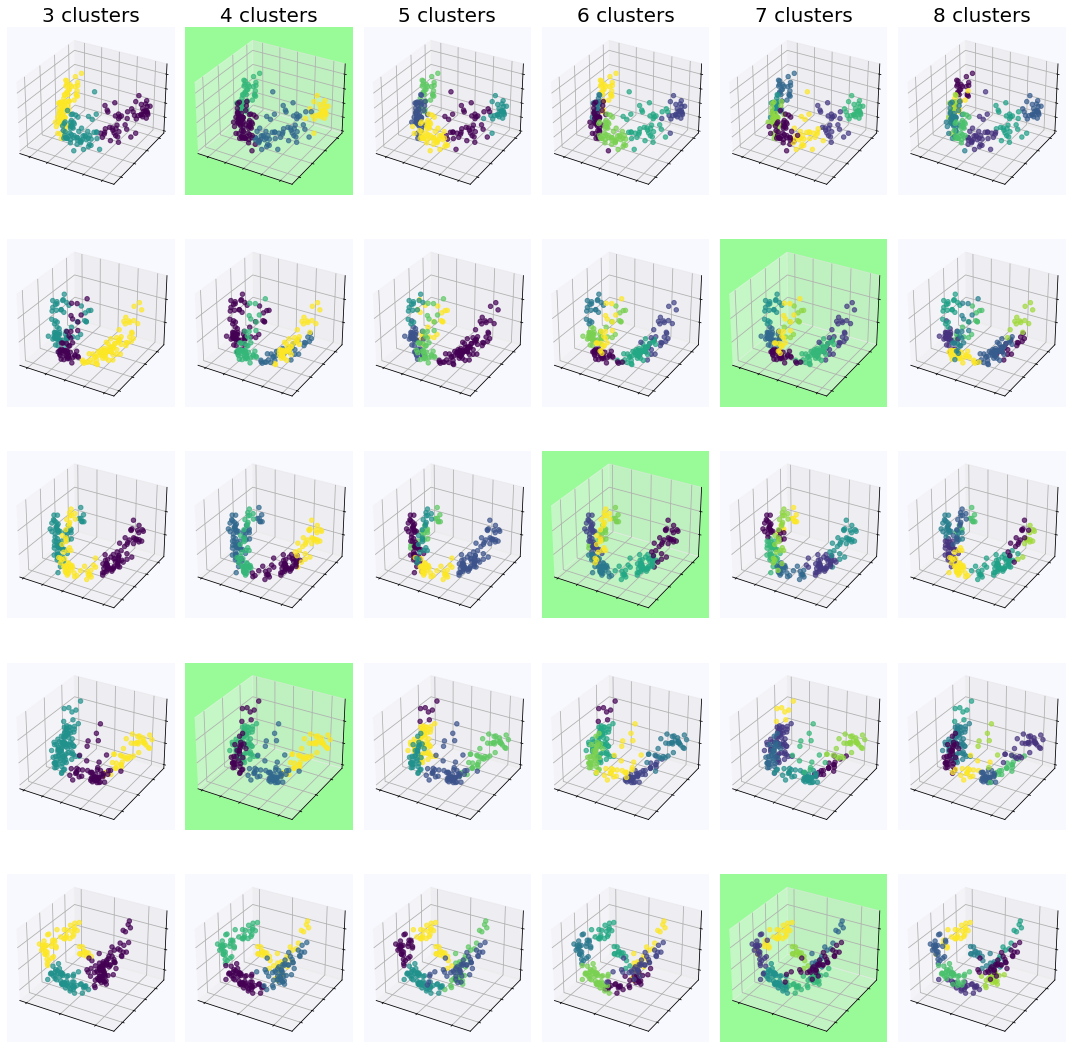

In [24]:
fig = plt.figure(figsize=(15, 15))

step = 1
for i in range(len(datasets)):
    
    best_bic = min(results[i]['bic'][3]['full'])
    best_bic_idx = results[i]['bic'][3]['full'].index(best_bic)
    
    for n_states in range(3, 9):
        idx = number_of_states.index(n_states)
            
        ax = fig.add_subplot(len(datasets), 6, step, projection='3d')
        ax.scatter(reduced[i][3].iloc[:, 0], reduced[i][3].iloc[:, 1], reduced[i][3].iloc[:, 2],
                   c=results[i]['pred'][3]['full'][idx], cmap='viridis', alpha=0.7)
        
        if i == 0:
            plt.title(f'{n_states} clusters', fontsize=20)

        if number_of_states[best_bic_idx] == n_states:
            ax.set_facecolor('palegreen')
        else:
            ax.set_facecolor('ghostwhite')
        
        plt.tight_layout()
        ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])

        step += 1
plt.savefig('PCA_3Dclusters.pdf', bbox_inches='tight', pad_inches = 0)

The results show that using $2$ components leads to more consistent results than using $3$ components. For the three first datasets the best model requires $5$ clusters, for the fourth dataset, requires $4$ clusters, while for the last dataset requires $7$ clusters. On the other hand, using $3$ components we obtain $4$ clusters for the first and fourth dataset, $6$ clusters for the second dataset and $8$ clusters for the third and last datasets. However, the differences in BIC score between these cases are not that large. One interesting observation is that in the last dataset there is a tendency to prefer a larger number of clusters, regardless of the number of components we choose. That may be justified by the odd shape of the dataset in comparison to the other four.

### T-SNE & GMM

As discussed previously, t-SNE works better for lower dimensions, thus we will use only two components to reduce the features of the initial datatsets. We have also discussed regarding the perplexity of t-SNE. To that end, we have concluded that the best value for the perplexity parameter is around 30. For fitting a Gaussian mixture model (GMM) on the data, we also need to specify the type of the covariance matrix, as well as the number of clusters (states). In order to decide on these parameters we ran a swipe over a range of values for these parameters and scored each model using both the BIC criterion and the Silhouette score.

In [25]:
number_of_components = [2]

reduced = []
results = []
for dataset in datasets:
    component_bic_scores = {}
    component_delta_bic_scores = {}
    component_pred = {}
    component_prob = {}
    component_silhouette = {}
    reduced.append({})
    for n in number_of_components:
        reduced[-1][n] = tsne(dataset, n)
        bic, delta_bic, predictions, prob_predictions, silhouette = gmm(reduced[-1][n], number_of_states)
        component_bic_scores[n] = bic
        component_delta_bic_scores[n] = delta_bic
        component_pred[n] = predictions
        component_prob[n] = prob_predictions
        component_silhouette[n] = silhouette
    results.append({
        'bic': component_bic_scores,
        'delta_bic': component_delta_bic_scores,
        'pred': component_pred,
        'probs': component_prob,
        'silhouette': component_silhouette
    })

/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/aspa/Desktop/MLCB/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aspa/

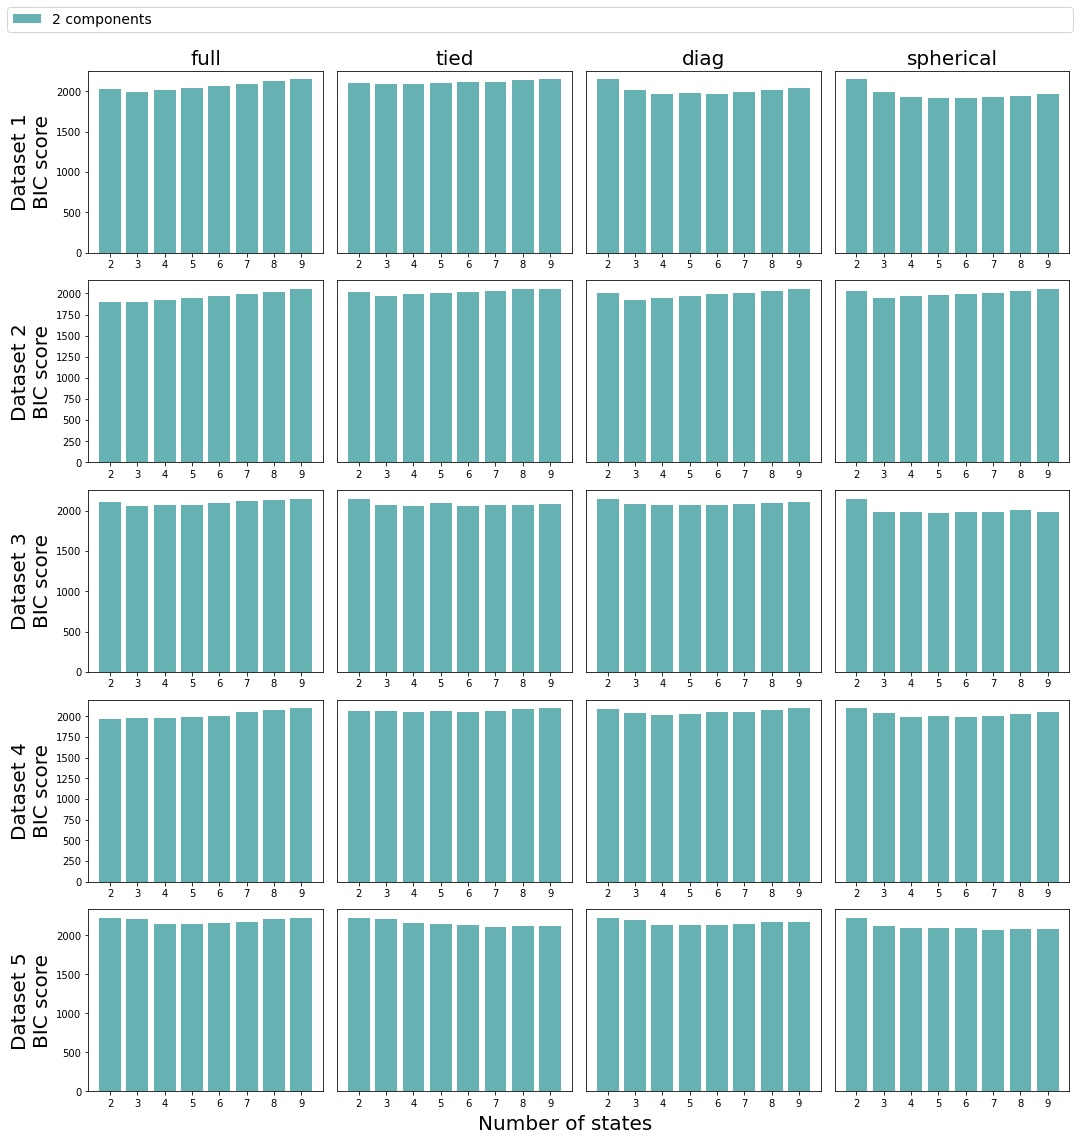

In [26]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['bic'].items()):
            
            l = f'{j + min(number_of_components)} components' if step == 1 else ''
            plt.bar(number_of_states, scores[cov_type], color=component_colors[j+5],
                    zorder=len(number_of_components)-j, label=l, alpha=0.6)

            if i == 0:
                plt.title(cov_type, fontsize=20)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\nBIC score', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4, fontsize=14)
plt.savefig('tsne_BIC.pdf', bbox_inches='tight', pad_inches = 0)

The results for the BIC score are presented above. Each row of the matrix refers to a specific dataset, while each column to a specific covariance matrix type. Every bar plot in the matrix plots the BIC score against the number of states (clusters) used by the GMM. Each bar color refers to the number of components for the t-SNE.

On the other hand,below depicts the $\Delta$BIC instead of BIC. In comparison to the previous pipeline, the results in this case suggest that not only the full covariance matrix type achieves its best BIC score using a smaller number of components, but the same stands also for the almost all the other covariance matrix type. They all seem to have the best BIC scores for 3 states.

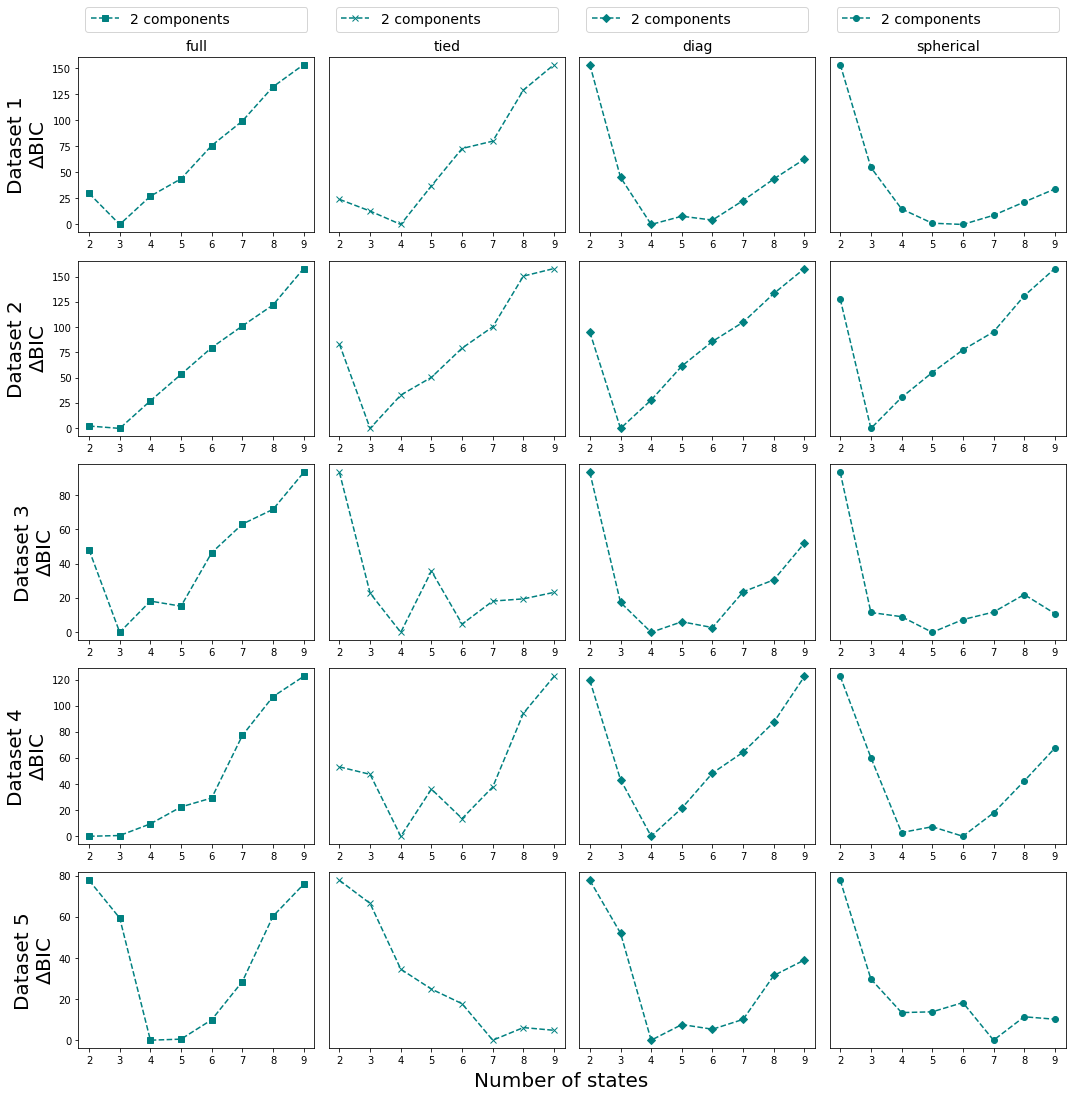

In [27]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['delta_bic'].items()):
            
            l = f'{j + min(number_of_components)} components' if step < 5 else ''
            plt.plot(number_of_states, scores[cov_type], color=component_colors[j+5], 
                     linestyle = '--', marker=cov_markers[cov_type], label=l)
        
            if i == 0:
                plt.title(cov_type, fontsize=14)
                plt.legend(bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=1, fontsize=14)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\n$\Delta$BIC', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
plt.savefig('tsne_DBIC.pdf', bbox_inches='tight', pad_inches = 0)

These observations are also supported by the figure below, that plots the Silhouette score instead of the BIC score.

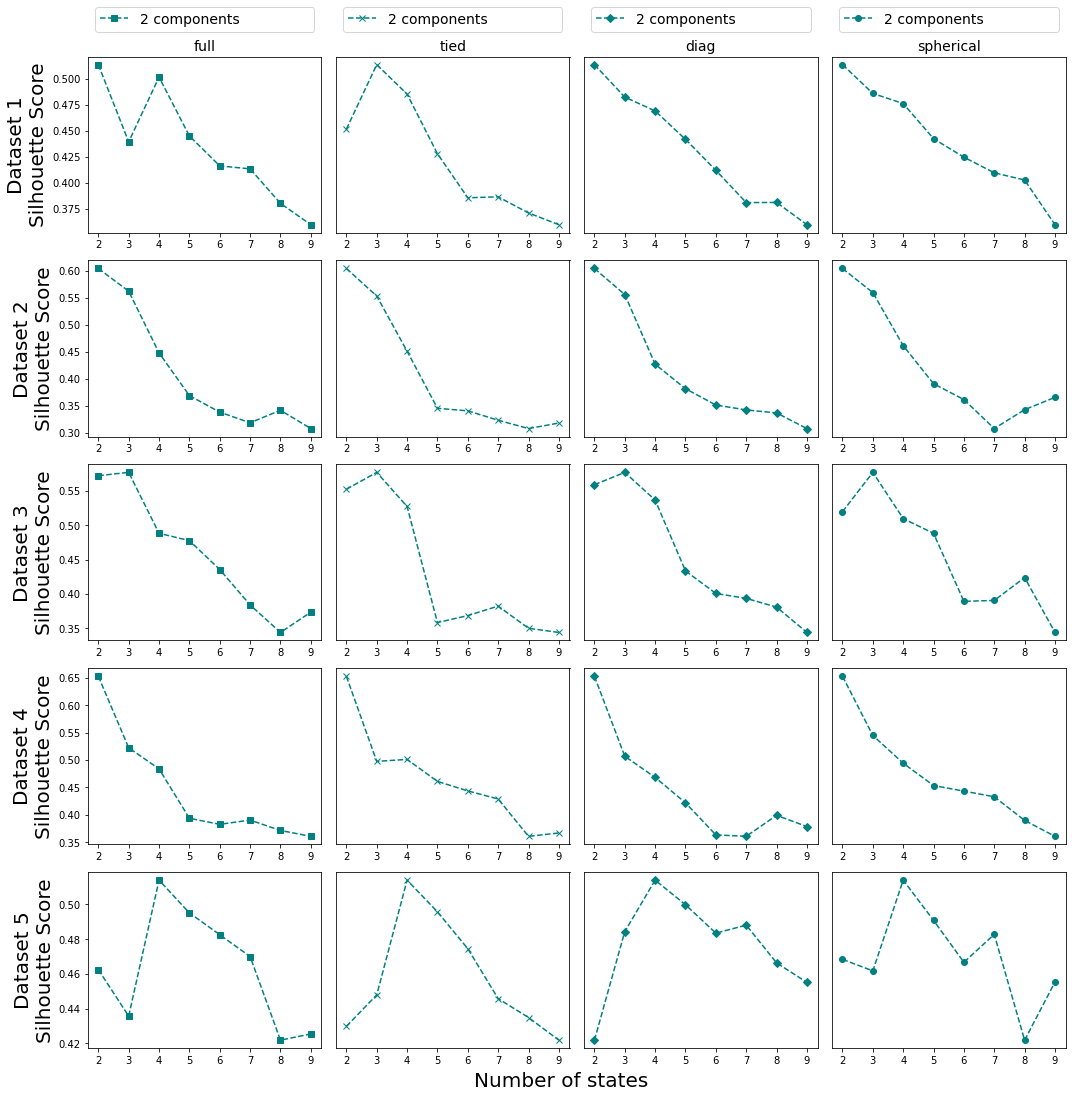

In [28]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['silhouette'].items()):
            
            l = f'{j + min(number_of_components)} components' if step < 5 else ''
            plt.plot(number_of_states, scores[cov_type], color=component_colors[j+5], 
                     linestyle = '--', marker=cov_markers[cov_type], label=l)
        
            if i == 0:
                plt.title(cov_type, fontsize=14)
                plt.legend(bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=1, fontsize=14)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\nSilhouette Score', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
plt.savefig('tsne_sihloutte.pdf', bbox_inches='tight', pad_inches = 0)

Below we plot a matrix of the GMM clustering results using only the full covariance matrix. For each dataset we mark using a green color the clustering that achieved the best BIC score. 

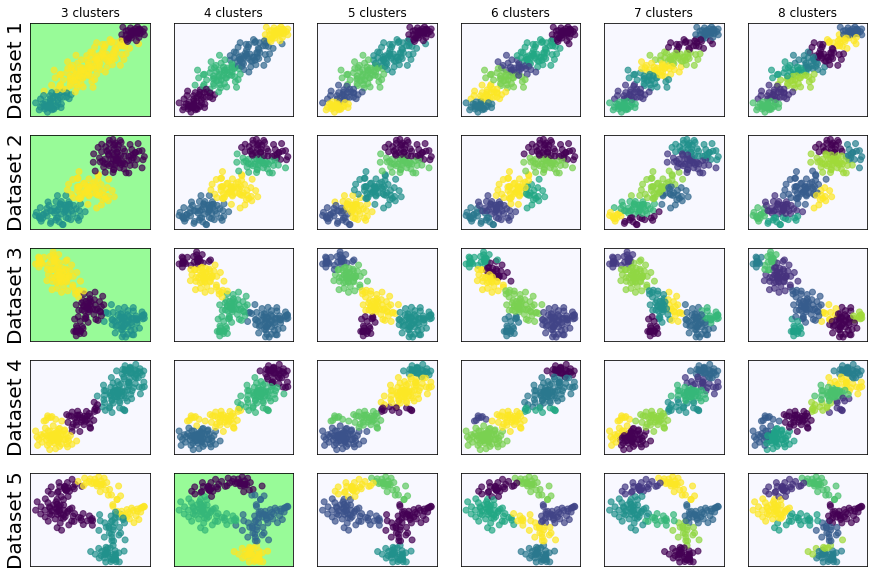

In [29]:
fig = plt.figure(figsize=(15, 10))

step = 1
for i in range(len(datasets)):
    
    best_bic = min(results[i]['bic'][2]['full'])
    best_bic_idx = results[i]['bic'][2]['full'].index(best_bic)
    
    for n_states in range(3, 9):
        idx = number_of_states.index(n_states)
            
        ax = plt.subplot(len(datasets), 6, step)
        plt.scatter(reduced[i][2].iloc[:, 0], reduced[i][2].iloc[:, 1], 
                    c=results[i]['pred'][2]['full'][idx], cmap='viridis', alpha=0.7)
        
        if i == 0:
            plt.title(f'{n_states} clusters')
        if step in [1, 7, 13, 19, 25]:
                plt.ylabel(f'Dataset {i+1}', fontsize=20)

        if number_of_states[best_bic_idx] == n_states:
            ax.set_facecolor('palegreen')
        else:
            ax.set_facecolor('ghostwhite')
        
        plt.xticks([]); plt.yticks([])

        step += 1
plt.savefig('tsne_2Dclusters.pdf', bbox_inches='tight', pad_inches = 0)

For the two datasets the best model requires $2$ clusters (not presented in this plot), for two dataset, requires $3$ clusters, while for the last dataset requires $4$ clusters. The last dataset also here requires the larger number of states, as observed in the previous section as well. In general, the t-SNE pipeline seems to have the worst performance so far, with respect to the BIC score, since it achieves twice the value of the respective PCA pipeline BIC scores. Finally, its performance can be attributed to the predicted structures.

### UMAP \& GMM

Similar to t-SNE and PCA, we performed the same exploratory analysis for the UMAP method. However, since UMAP can perform reduction in any number of dimension, in contrast to t-SNE, and we did not have an intuitive method, similar to PCA in order to get an appropriate range of components to evaluate, we picked a range from $2$ to $8$. The figure below presents the BIC score for all different components. The results indicate a preference for $8$ components in some datasets, while for others $2$-$3$ components seem to suffice. However, the largest preference towards $8$ components is present in dataset $5$ that has an odd shape with respect to the rest of the datasets.

In [30]:
number_of_components = [2, 3, 4, 5, 6, 7, 8]

reduced = []
results = []
for dataset in datasets:
    component_bic_scores = {}
    component_delta_bic_scores = {}
    component_pred = {}
    component_prob = {}
    component_silhouette = {}
    reduced.append({})
    for n in number_of_components:
        reduced[-1][n] = _umap(dataset, n)
        bic, delta_bic, predictions, prob_predictions, silhouette = gmm(reduced[-1][n], number_of_states)
        component_bic_scores[n] = bic
        component_delta_bic_scores[n] = delta_bic
        component_pred[n] = predictions
        component_prob[n] = prob_predictions
        component_silhouette[n] = silhouette
    results.append({
        'bic': component_bic_scores,
        'delta_bic': component_delta_bic_scores,
        'pred': component_pred,
        'probs': component_prob,
        'silhouette': component_silhouette
    })

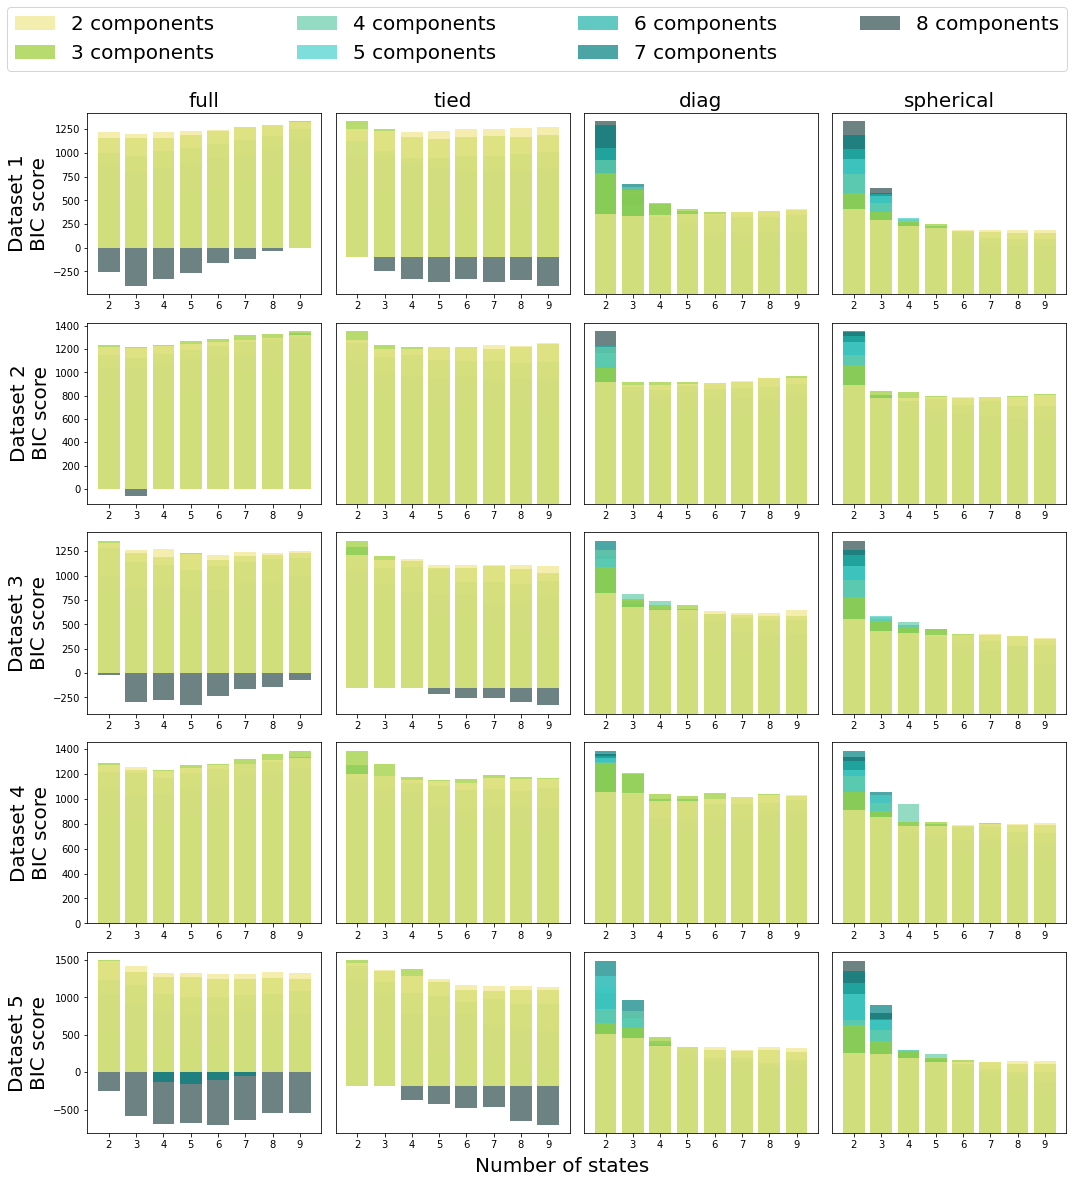

In [31]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['bic'].items()):
            
            l = f'{j + min(number_of_components)} components' if step == 1 else ''
            plt.bar(number_of_states, scores[cov_type], color=component_colors[j],
                    zorder=len(number_of_components)-j, label=l, alpha=0.7)

            if i == 0:
                plt.title(cov_type, fontsize=20)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\nBIC score', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4, fontsize=20)
plt.savefig('umap_BIC.pdf', bbox_inches='tight', pad_inches = 0)

The plots below present the results for $\Delta$BIC and Silhouette score. These results suggest once again that the full covariance matrix seem to need less clusters in order to achieve a good clustering compared with the other covariance matrices. The Silhouette results show that although the BIC score seem to be better on some datasets when choosing a larger number of components, even using $2$ or $3$ components has comparable quality in terms of the Silhouette score.

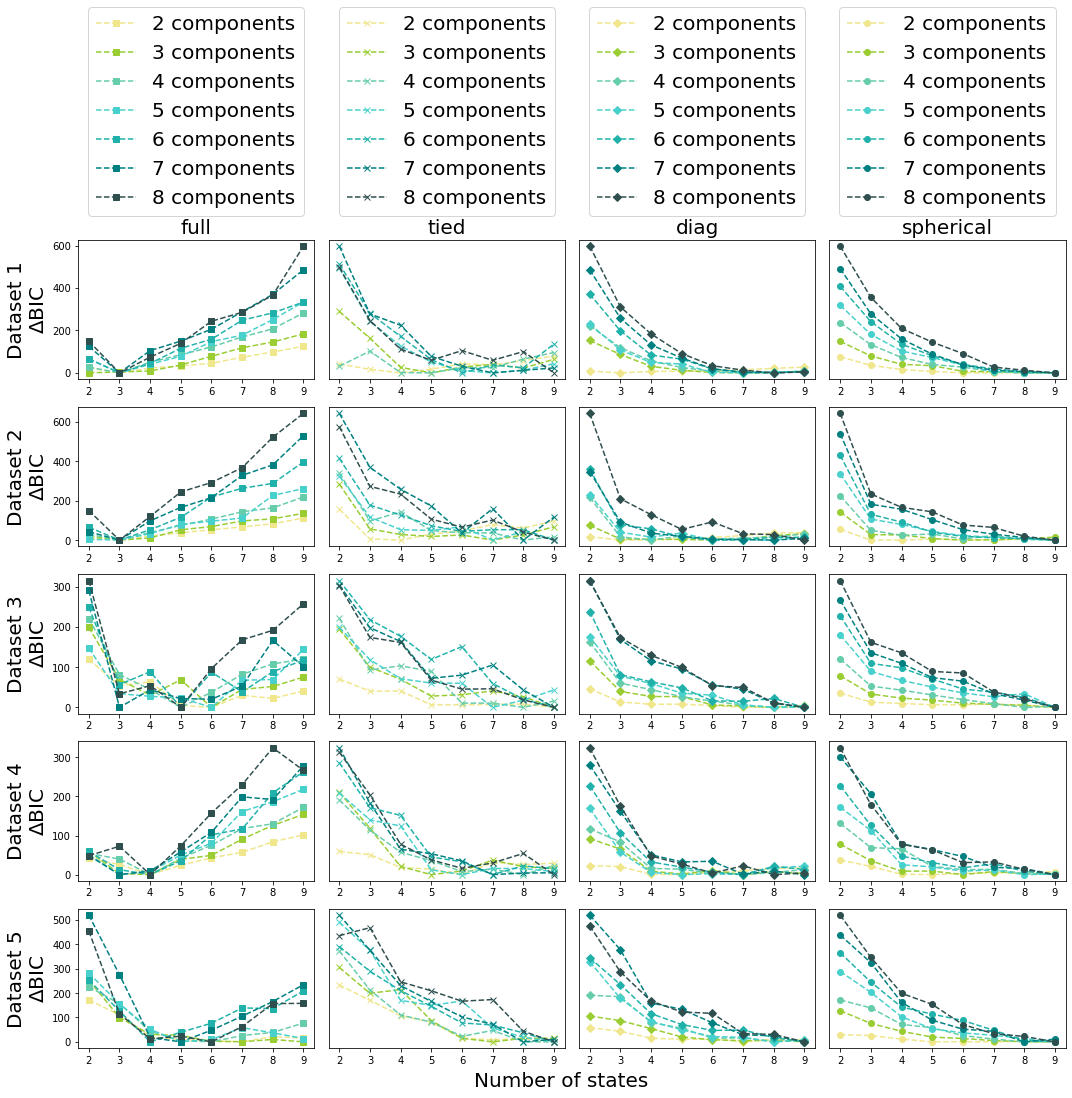

In [32]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['delta_bic'].items()):
            
            l = f'{j + min(number_of_components)} components' if step < 5 else ''
            plt.plot(number_of_states, scores[cov_type], color=component_colors[j], 
                     linestyle = '--', marker=cov_markers[cov_type], label=l)
        
            if i == 0:
                plt.title(cov_type, fontsize=20)
                plt.legend(bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=1, fontsize=20)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\n$\Delta$BIC', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
plt.savefig('umap_DBIC.pdf', bbox_inches='tight', pad_inches = 0)

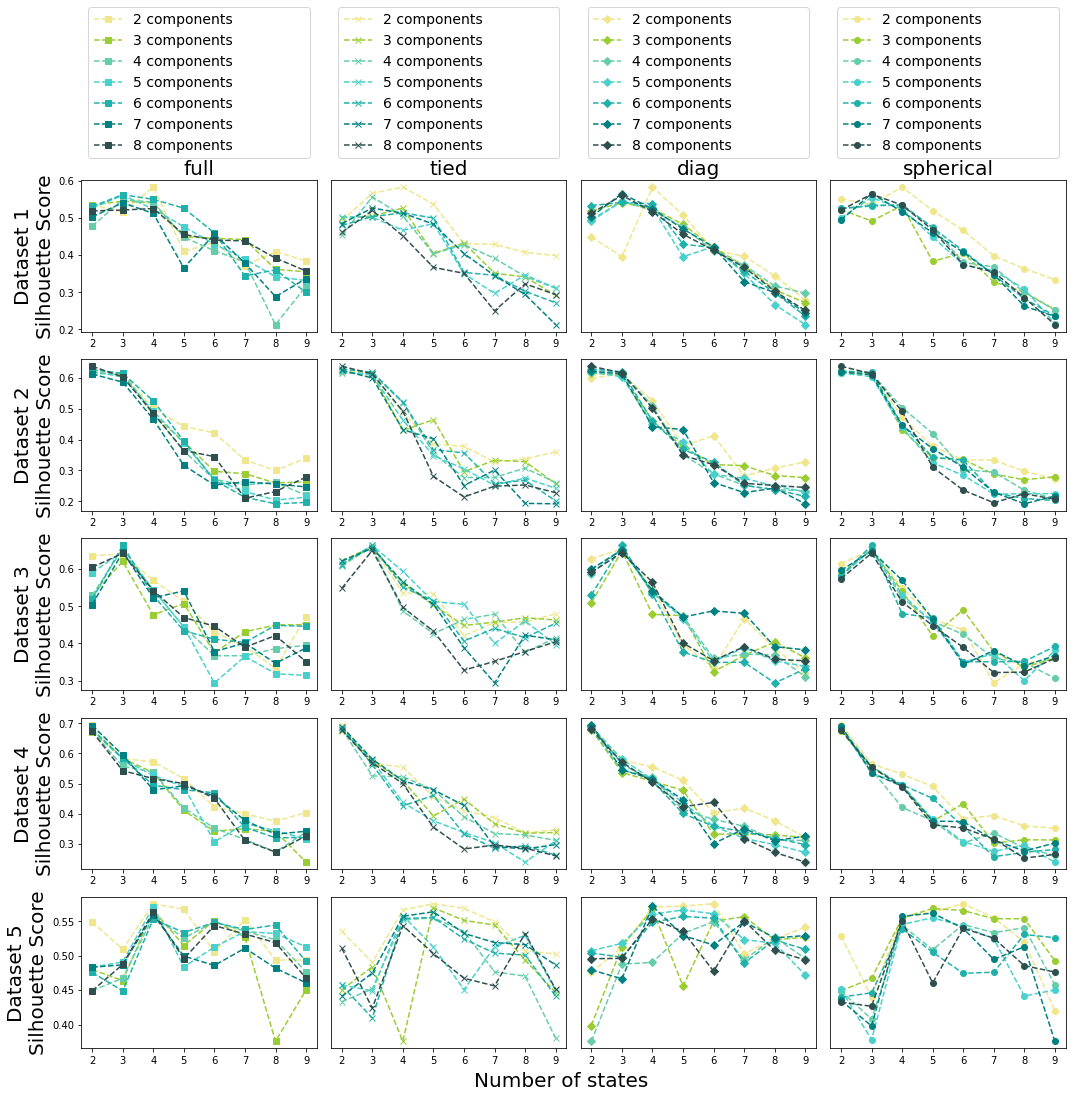

In [33]:
fig = plt.figure(figsize=(15, 15))

step = 1
cov_types = list(results[0]['bic'][list(results[0]['bic'].keys())[0]].keys())
for i in range(len(datasets)):
    
    for cov_type in cov_types:
        plt.subplot(len(datasets), len(cov_types), step)
        for j, (n, scores) in enumerate(results[i]['silhouette'].items()):
            
            l = f'{j + min(number_of_components)} components' if step < 5 else ''
            plt.plot(number_of_states, scores[cov_type], color=component_colors[j], 
                     linestyle = '--', marker=cov_markers[cov_type], label=l)
        
            if i == 0:
                plt.title(cov_type, fontsize=20)
                plt.legend(bbox_to_anchor=(0, 1.1, 1, 0), loc="lower left", mode="expand", ncol=1, fontsize=14)
            
            if step in [1, 5, 9, 13, 17]:
                plt.ylabel(f'Dataset {i+1}\nSilhouette Score', fontsize=20)
            else:
                plt.yticks([])
            
            plt.xticks(number_of_states)
            plt.tight_layout()
            
        step += 1

fig.text(0.523, -0.01, 'Number of states', ha='center', fontsize=20)
plt.savefig('umap_sihlouette.pdf', bbox_inches='tight', pad_inches = 0)

Finally, the plots below depict the clustering results for $2$ and $3$ components respectively. 

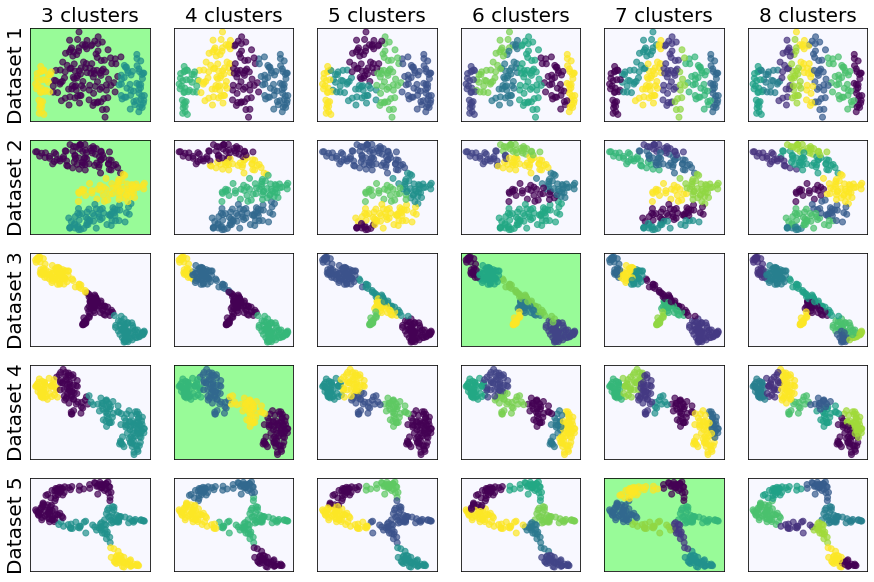

In [34]:
fig = plt.figure(figsize=(15, 10))

step = 1
for i in range(len(datasets)):
    
    best_bic = min(results[i]['bic'][2]['full'])
    best_bic_idx = results[i]['bic'][2]['full'].index(best_bic)
    
    for n_states in range(3, 9):
        idx = number_of_states.index(n_states)
        
        ax = plt.subplot(len(datasets), 6, step)
        plt.scatter(reduced[i][2].iloc[:, 0], reduced[i][2].iloc[:, 1], 
                    c=results[i]['pred'][2]['full'][idx], cmap='viridis', alpha=0.7)
        
        if i == 0:
            plt.title(f'{n_states} clusters', fontsize=20)
        if step in [1, 7, 13, 19, 25]:
                plt.ylabel(f'Dataset {i+1}', fontsize=20)
        
        if number_of_states[best_bic_idx] == n_states:
            ax.set_facecolor('palegreen')
        else:
            ax.set_facecolor('ghostwhite')
        
        plt.xticks([]); plt.yticks([])
        
        step += 1
plt.savefig('umap_2Dclusters.pdf', bbox_inches='tight', pad_inches = 0)

/tmp/ipykernel_15178/3871342727.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/tmp/ipykernel_15178/3871342727.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


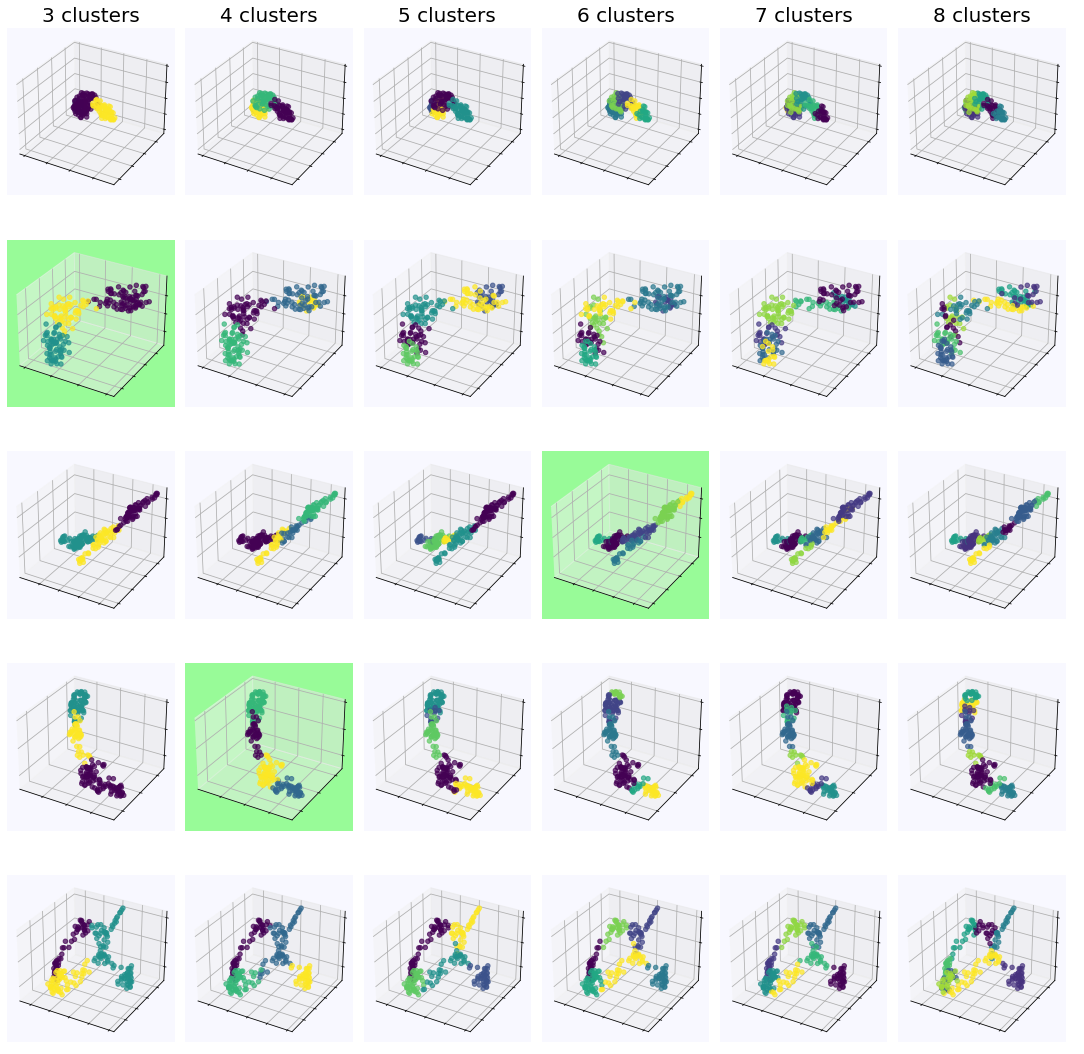

In [35]:
fig = plt.figure(figsize=(15, 15))

step = 1
for i in range(len(datasets)):
    
    best_bic = min(results[i]['bic'][3]['full'])
    best_bic_idx = results[i]['bic'][3]['full'].index(best_bic)
    
    for n_states in range(3, 9):
        idx = number_of_states.index(n_states)
        
        ax = fig.add_subplot(len(datasets), 6, step, projection='3d')
        ax.scatter(reduced[i][3].iloc[:, 0], reduced[i][3].iloc[:, 1], reduced[i][3].iloc[:, 2],
                   c=results[i]['pred'][3]['full'][idx], cmap='viridis', alpha=0.7)
        
        if i == 0:
            plt.title(f'{n_states} clusters', fontsize=20)

        if number_of_states[best_bic_idx] == n_states:
            ax.set_facecolor('palegreen')
        else:
            ax.set_facecolor('ghostwhite')
        
        plt.tight_layout()
        ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])

        step += 1
plt.savefig('umap_3Dclusters.pdf', bbox_inches='tight', pad_inches = 0)

These results show that $3$ to $5$ clusters are required in the $2$-dimensional case for datasets $1$ through $4$, while the fifth dataset still seem to require $7$ clusters in the best model. The same holds in $3$ dimensions, where $3$ or $4$ clusters suffice for the first four datasets, whule the fifth requires $6$ clusters.

## Conclusions
#### Best Model


The analysis performed using the three dimensionality reduction techniques overall indicates that $2$ components seem to suffice for approximating the true distribution of the data. Specifically, both PCA and UMAP seem to give good results for $2$ components, however UMAP seem to generate higher quality embeddings in higher dimensions leading to consistent clustering results across all datasets. On the other hand t-SNE seem to yield weak results and cannot be used for generating embeddings in more than $3$ dimensions.\\

Using UMAP and $2$ components we can conclude that a good approximation of the true distribution is given using $4$ clusters since the first four dataset seem to yield good results for $4$ clusters, while the fifth seems to be an outlier that always prefers more clusters in order to explain the underlying data.\\

The plot below presents the posterior distribution of all five datasets using UMAP with $2$ components and GMM using a full covariance matrix and $4$ states (clusters).

In [ ]:
fig = plt.figure(figsize=(20, 4))

for i in range(len(datasets)):
    
    best_bic = min(results[i]['bic'][2]['full'])
    best_bic_idx = results[i]['bic'][2]['full'].index(best_bic)
    
    n_states = 4
    idx = number_of_states.index(n_states)

    ax = plt.subplot(1, len(datasets), i+1)
    plt.scatter(reduced[i][2].iloc[:, 0], reduced[i][2].iloc[:, 1], 
                c=results[i]['probs'][2]['full'][idx], alpha=0.6)
    ax.set_facecolor('ghostwhite')

    plt.title(f'Dataset {i+1}', fontsize=20)
    plt.xticks([]); plt.yticks([])

plt.savefig('posteriors_4states.pdf', bbox_inches='tight', pad_inches = 0)

We also show the same plot for three clusters instead of four.

In [ ]:
fig = plt.figure(figsize=(20, 4))

for i in range(len(datasets)):
    
    best_bic = min(results[i]['bic'][2]['full'])
    best_bic_idx = results[i]['bic'][2]['full'].index(best_bic)
    
    n_states = 3
    idx = number_of_states.index(n_states)

    ax = plt.subplot(1, len(datasets), i+1)
    plt.scatter(reduced[i][2].iloc[:, 0], reduced[i][2].iloc[:, 1], 
                c=results[i]['probs'][2]['full'][idx], alpha=0.6)
    ax.set_facecolor('ghostwhite')

    plt.title(f'Dataset {i+1}', fontsize=20)
    plt.xticks([]); plt.yticks([])

plt.savefig('posteriors_3states.pdf', bbox_inches='tight', pad_inches = 0)